# Big Mart Sales

>. To build a regression methodology to determine the sales of items at a particular outlet.

## How to run this notebook??

- ensure the input data absolute path is 'Sales_Training.csv' 
- import the libraries (1.2)
- run all the functions (1.10)
- run sequentially (1.3 onwards)

## Importing the Libraries

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
import time 
from datetime import datetime
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from sklearn.metrics import davies_bouldin_score
import scipy.cluster.hierarchy as shc

from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics
from time import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Reading the Data

In [131]:
df_main=pd.read_csv('Sales_Training.csv')
df_main.head(5)

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Item_Outlet_Sales,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Outlet_Size_3,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,9.30,0.016047,249.8092,OUT049,3735.1380,10,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.92,0.019278,48.2692,OUT018,443.4228,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.50,0.016760,141.6180,OUT049,2097.2700,10,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,FDX07,19.20,0.017834,182.0950,OUT010,732.3800,11,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.009780,53.8614,OUT013,994.7052,22,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


In [132]:
df_main.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3',
       'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

In [258]:
x=df_main[['Outlet_Identifier','Item_Identifier']].groupby(['Item_Identifier'])['Outlet_Identifier'].agg({'nunique'})
x[x['nunique']>1]

,nunique
Item_Identifier,
DRA12,4
DRB13,2
DRB48,4
DRC27,2
DRD24,3
...,...
NCY41,4
NCZ06,4
NCZ18,3


In [254]:
df_main[['Outlet_Identifier','Item_Identifier']].groupby(['Outlet_Identifier'])['Item_Identifier'].agg({'count','nunique'})

,count,nunique
Outlet_Identifier,,
OUT010,295,121
OUT013,555,225
OUT017,557,215
OUT018,524,203
OUT019,317,125
OUT027,530,227
OUT035,560,221
OUT045,580,235
OUT046,548,224


<b>insights</b>
- one outlet has multiple products & one product could be sold in multiple outlets. we will keep item id as prediction index, as for outlet identifier, it can be discarded as there are 10 different outlets & its already one hot encoded to produce the columns [Outlet_0],[Outlet_1] ,[Outlet_2]  ,[Outlet_3]   ,[Outlet_4]   ,[Outlet_5]   ,[Outlet_6]  ,[Outlet_7] ,[Outlet_8]
,[Outlet_9].

- the table below shows 'OUTLET_IDENTIFIER' based on the values of outlet_i where i is number of outlets -1

In [264]:
df_main[['Outlet_Identifier','Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9']].drop_duplicates().reset_index(drop=True)

,Outlet_Identifier,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,OUT049,0,0,0,0,0,0,0,0,0,1
1,OUT018,0,0,0,1,0,0,0,0,0,0
2,OUT010,1,0,0,0,0,0,0,0,0,0
3,OUT013,0,1,0,0,0,0,0,0,0,0
4,OUT027,0,0,0,0,0,1,0,0,0,0
5,OUT045,0,0,0,0,0,0,0,1,0,0
6,OUT017,0,0,1,0,0,0,0,0,0,0
7,OUT046,0,0,0,0,0,0,0,0,1,0
8,OUT035,0,0,0,0,0,0,1,0,0,0
9,OUT019,0,0,0,0,1,0,0,0,0,0


In [133]:
df=df_main.copy()

## Exploratory Data Analysis
there are main components of exploring data:
- Understanding your variables
- Cleaning your dataset
- Analyzing relationships between variables

### List of Columns

In [134]:
print('list of parameters in the data ')
df.columns

list of parameters in the data 


Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3',
       'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

In [135]:
print('number of rows in the data',df.shape[0])
print('number of columns in the data',df.shape[1])

number of rows in the data 5005
number of columns in the data 33


### Summary Statistics 

In [136]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,5005.0,13.012739,4.570505,4.59000,9.000000,13.000000,16.850000,21.350000
Item_Visibility,5005.0,0.071238,0.049871,0.00478,0.032284,0.061331,0.098664,0.328391
Item_MRP,5005.0,142.253086,62.656992,31.29000,93.912000,145.047000,187.387200,265.222600
Item_Outlet_Sales,5005.0,2233.863293,1754.290056,33.29000,866.871600,1808.312800,3125.931000,11445.102000
Outlet_Years,5005.0,11.133467,8.354372,0.00000,5.000000,10.000000,22.000000,24.000000
Item_Fat_Content_0,5005.0,0.654745,0.475499,0.00000,0.000000,1.000000,1.000000,1.000000
Item_Fat_Content_1,5005.0,0.345255,0.475499,0.00000,0.000000,0.000000,1.000000,1.000000
Outlet_Location_Type_0,5005.0,0.280519,0.449298,0.00000,0.000000,0.000000,1.000000,1.000000
Outlet_Location_Type_1,5005.0,0.339061,0.473438,0.00000,0.000000,0.000000,1.000000,1.000000
Outlet_Location_Type_2,5005.0,0.380420,0.485538,0.00000,0.000000,0.000000,1.000000,1.000000


<b> Insights </b>
- all columns have count of 200 i.e there are no null values in any column
- but there is '?' instead

In [137]:
df.replace('?', np.NAN, inplace=True)

### Null values per column

In [138]:
#double check the null values
print('Null values in the number of columns ?')
df.isnull().any().sum()

Null values in the number of columns ?


0

In [139]:
df.isnull().sum()

Item_Identifier           0
Item_Weight               0
Item_Visibility           0
Item_MRP                  0
Outlet_Identifier         0
Item_Outlet_Sales         0
Outlet_Years              0
Item_Fat_Content_0        0
Item_Fat_Content_1        0
Outlet_Location_Type_0    0
Outlet_Location_Type_1    0
Outlet_Location_Type_2    0
Outlet_Size_0             0
Outlet_Size_1             0
Outlet_Size_2             0
Outlet_Size_3             0
Outlet_Type_0             0
Outlet_Type_1             0
Outlet_Type_2             0
Outlet_Type_3             0
Item_Type_Combined_0      0
Item_Type_Combined_1      0
Item_Type_Combined_2      0
Outlet_0                  0
Outlet_1                  0
Outlet_2                  0
Outlet_3                  0
Outlet_4                  0
Outlet_5                  0
Outlet_6                  0
Outlet_7                  0
Outlet_8                  0
Outlet_9                  0
dtype: int64

In [140]:
bool_value= False
columns_with_null = []

count_null = df.isnull().sum()
for count_ in count_null:
    if count_ > 0:
        bool_value= True

if bool_value:
    null_df = pd.DataFrame(count_null).reset_index().rename(columns={'index': 'col_name', 0:'no_of_nulls'})
    columns_with_null = list(null_df[null_df['no_of_nulls'] > 0]['col_name'].values)

In [141]:
columns_with_null

[]

### Data types of columns

In [142]:
#checking for data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5005 entries, 0 to 5004
Data columns (total 33 columns):
Item_Identifier           5005 non-null object
Item_Weight               5005 non-null float64
Item_Visibility           5005 non-null float64
Item_MRP                  5005 non-null float64
Outlet_Identifier         5005 non-null object
Item_Outlet_Sales         5005 non-null float64
Outlet_Years              5005 non-null int64
Item_Fat_Content_0        5005 non-null int64
Item_Fat_Content_1        5005 non-null int64
Outlet_Location_Type_0    5005 non-null int64
Outlet_Location_Type_1    5005 non-null int64
Outlet_Location_Type_2    5005 non-null int64
Outlet_Size_0             5005 non-null int64
Outlet_Size_1             5005 non-null int64
Outlet_Size_2             5005 non-null int64
Outlet_Size_3             5005 non-null int64
Outlet_Type_0             5005 non-null int64
Outlet_Type_1             5005 non-null int64
Outlet_Type_2             5005 non-null int64
Outlet_Ty

### Encoding Categorical Columns

from doccumentation we know , we have the following as categorical features, but its already one hot encoded data.

#### Data Distribution

In [143]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3',
       'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

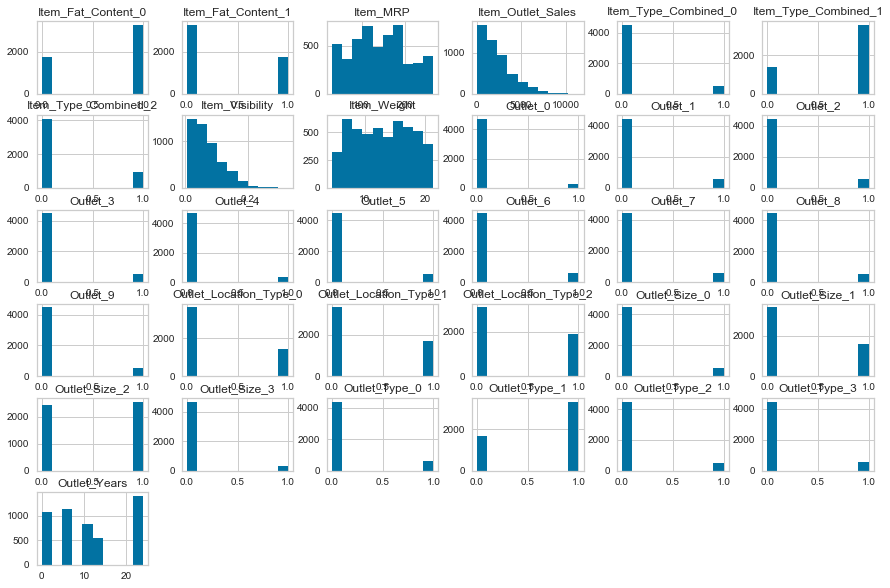

In [144]:
p=df.hist(figsize=(15,10))

###  Outlier detection

#### Box Plot 

In [145]:
df_main.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3',
       'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

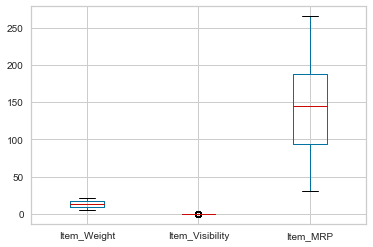

In [146]:
df[['Item_Weight', 'Item_Visibility', 'Item_MRP']].boxplot()

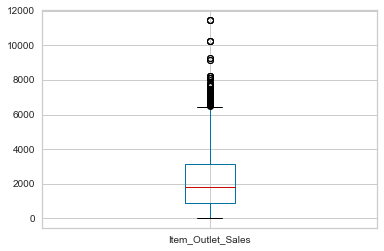

In [147]:
df[['Item_Outlet_Sales']].boxplot()

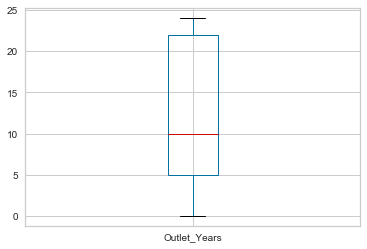

In [148]:
df[['Outlet_Years']].boxplot()

### Relationship between Parameters 

#### Item_MRP

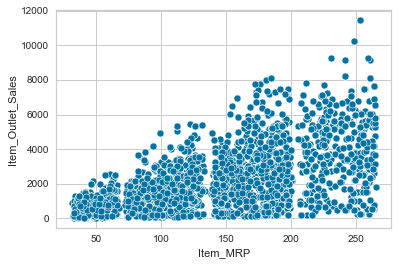

In [149]:
p=sns.scatterplot(df_main["Item_MRP"],df_main["Item_Outlet_Sales"])

#### Item_Visibility


In [150]:
df_main['Item_Visibility'].unique()

array([0.0160473 , 0.01927822, 0.01676007, ..., 0.03922186, 0.02158192,
       0.128206  ])

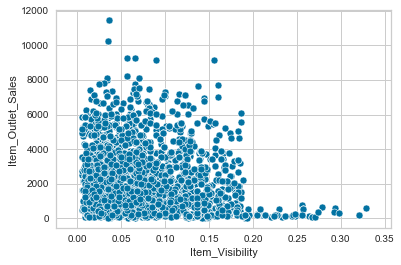

In [151]:
p=sns.scatterplot(df_main["Item_Visibility"],df_main["Item_Outlet_Sales"])

#### Outlet Years

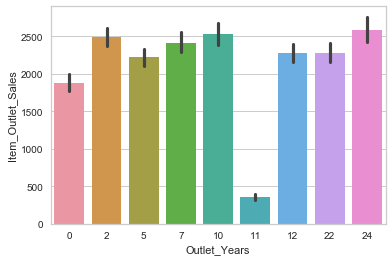

In [152]:
p=sns.barplot(df_main["Outlet_Years"],df_main["Item_Outlet_Sales"])

#### Outlet name

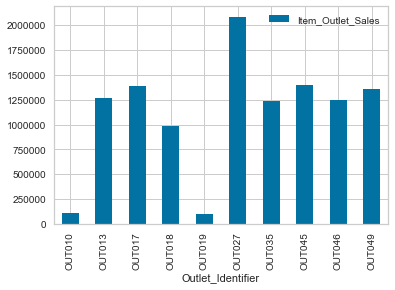

In [153]:
temp=df_main[["Outlet_Identifier",'Item_Outlet_Sales']].groupby(["Outlet_Identifier"]).agg({'Item_Outlet_Sales':'sum'})
temp.plot(kind="bar")

Text(0.5, 1.0, 'Outlet_Identifier vs Item_Outlet_Sales ')

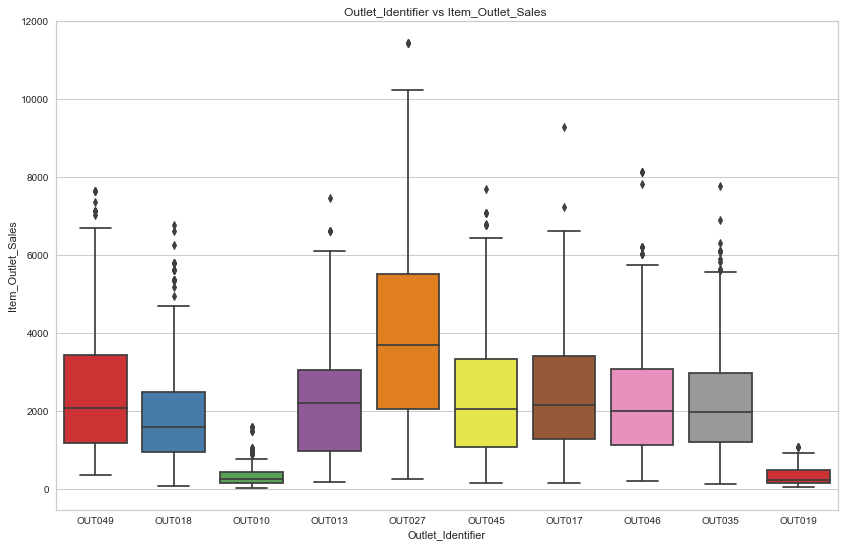

In [154]:
plt.figure(figsize = (14,9))
sns.boxplot(x='Outlet_Identifier', y='Item_Outlet_Sales', data=df_main, palette="Set1")
plt.title("Outlet_Identifier vs Item_Outlet_Sales ")

#### Item Type


In [155]:
x,y,z = df_main[df_main["Item_Type_Combined_0"]==1],df_main[df_main["Item_Type_Combined_1"]==1],df_main[df_main["Item_Type_Combined_2"]==1]

In [156]:
df_pie = pd.DataFrame([[x.shape[0],y.shape[0],z.shape[0]]], columns=["Item_Type_Combined_0","Item_Type_Combined_1","Item_Type_Combined_2"])

In [157]:
df_pie

,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2
0,482,3609,914


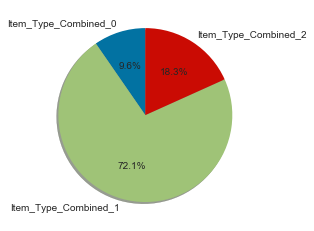

In [158]:
plt.pie(df_pie, labels=df_pie.columns, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

In [159]:
column= ["Item_Type_Combined_0","Item_Type_Combined_1","Item_Type_Combined_2"]
for col in column:
    print(col,df_main[df_main[col]==1][col].value_counts()[1])

Item_Type_Combined_0 482
Item_Type_Combined_1 3609
Item_Type_Combined_2 914


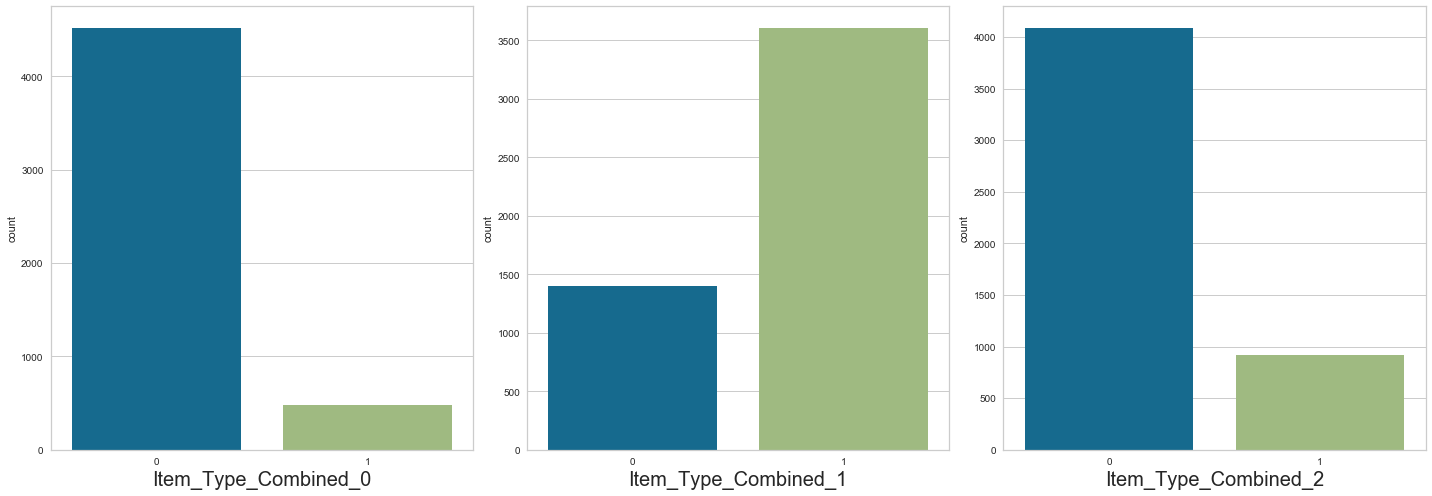

In [160]:
plt.figure(figsize=(20,7), facecolor='white')
plotnumber = 1
for column in ["Item_Type_Combined_0","Item_Type_Combined_1","Item_Type_Combined_2"]:
    ax = plt.subplot(1,3,plotnumber)
    sns.countplot(x = column,data = df_main,ax=ax)
    plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.tight_layout()

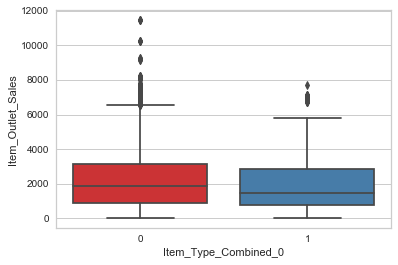

In [161]:
sns.boxplot(x='Item_Type_Combined_0', y='Item_Outlet_Sales', data=df_main, palette="Set1")

#### Item Fat Content

In [162]:
x,y = df_main[df_main["Item_Fat_Content_0"]==1],df_main[df_main["Item_Fat_Content_1"]==1]
df_pie = pd.DataFrame([[x.shape[0],y.shape[0]]], columns=["Item_Fat_Content_0","Item_Fat_Content_1"])

In [163]:
df_pie

,Item_Fat_Content_0,Item_Fat_Content_1
0,3277,1728


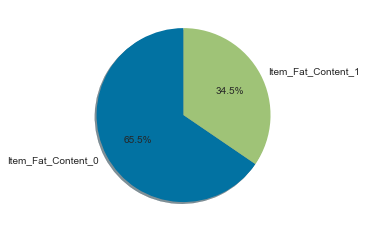

In [164]:
plt.pie(df_pie, labels=df_pie.columns, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

#### Outlet Location

In [165]:
x=df_main[df_main["Outlet_Location_Type_0"]==1]['Item_Outlet_Sales'].sum()
y=df_main[df_main["Outlet_Location_Type_1"]==1]['Item_Outlet_Sales'].sum()
z=df_main[df_main["Outlet_Location_Type_2"]==1]['Item_Outlet_Sales'].sum()
temp=pd.DataFrame([x,y,z],index=["Outlet_Location_Type_0","Outlet_Location_Type_1","Outlet_Location_Type_2"],columns=['sales'])
temp.head()

,sales
Outlet_Location_Type_0,2.712625e+06
Outlet_Location_Type_1,4.027673e+06
Outlet_Location_Type_2,4.440188e+06


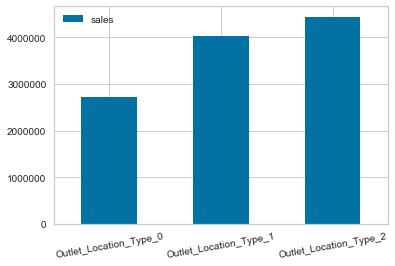

In [166]:
temp.plot(kind='bar',rot=10)

#### Sales by Product

In [167]:
df_main['Item_Identifier'].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'FDZ43', 'FDJ50', 'FDV35'],
      dtype=object)

In [168]:
temp=df_main[["Item_Identifier",'Item_Outlet_Sales']].groupby(["Item_Identifier"]).agg({'Item_Outlet_Sales':'sum'})
temp['Item_Outlet_Sales']=round(temp['Item_Outlet_Sales'],2)
temp=temp.sort_values(by = 'Item_Outlet_Sales',ascending=False)

##### Top 20 selling products

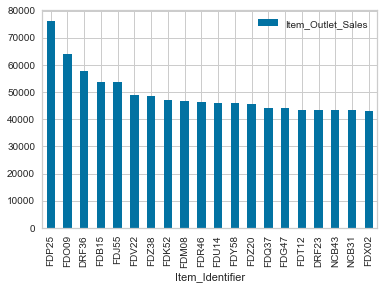

In [169]:
temp.head(20).plot(kind='bar')

##### Bottom  20 selling products

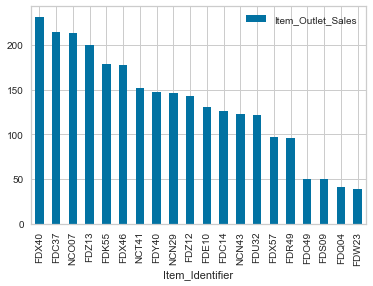

In [170]:
temp.tail(20).plot(kind='bar')

### Correlation matrix and its heat map
- <b>A correlation matrix </b>is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses.

In [171]:
df_main.corr()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Outlet_Size_3,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
Item_Weight,1.000000,-0.028674,-0.000255,0.010784,0.016975,0.024335,-0.024335,-0.022108,0.012272,0.008492,0.010177,-0.033718,0.014391,0.022577,0.014369,-0.000673,-0.028762,0.014350,-0.060947,0.010059,0.034861,0.022577,0.010177,0.012942,-0.028762,-0.002504,0.014350,0.014923,-0.009263,0.006385,-0.036504
Item_Visibility,-0.028674,1.000000,-0.030495,-0.141637,0.100036,-0.032534,0.032534,0.070483,-0.091197,0.023702,-0.022856,-0.081995,0.006719,0.178385,0.293736,-0.154702,-0.031459,-0.044514,-0.025330,0.048820,-0.037328,0.178385,-0.022856,-0.042400,-0.031459,0.222598,-0.044514,-0.056060,-0.038007,-0.024618,-0.047956
Item_MRP,-0.000255,-0.030495,1.000000,0.586390,0.003133,-0.026634,0.026634,-0.016943,0.025257,-0.008949,0.005037,-0.017949,0.021439,-0.016716,-0.026162,0.022409,-0.019139,0.012579,-0.062313,0.066332,-0.029417,-0.016716,0.005037,0.006770,-0.019139,-0.019026,0.012579,-0.004686,0.035316,0.010870,-0.020555
Item_Outlet_Sales,0.010784,-0.141637,0.586390,1.000000,0.059710,-0.032061,0.032061,-0.107430,0.056979,0.043853,0.009033,0.213349,-0.078258,-0.267919,-0.402819,0.106981,-0.068616,0.333309,-0.042982,0.061257,-0.038286,-0.267919,0.009033,0.051358,-0.068616,-0.282744,0.333309,-0.003498,0.037254,0.008891,0.057511
Outlet_Years,0.016975,0.100036,0.003133,0.059710,1.000000,0.020204,-0.020204,0.209903,-0.551707,0.343721,0.459396,0.019224,-0.304608,-0.003999,0.294904,-0.255029,-0.455762,0.530069,-0.003756,0.027430,-0.028972,-0.003999,0.459396,-0.386910,-0.455762,0.400523,0.530069,-0.260612,-0.179144,0.036373,-0.047138
Item_Fat_Content_0,0.024335,-0.032534,-0.026634,-0.032061,0.020204,1.000000,-1.000000,0.042783,-0.038263,-0.002281,-0.036649,0.033371,-0.008792,0.001517,0.031165,-0.042978,0.010862,0.021831,0.170101,-0.407589,0.343235,0.001517,-0.036649,-0.019633,0.010862,0.040452,0.021831,-0.023539,-0.014116,0.012381,0.017748
Item_Fat_Content_1,-0.024335,0.032534,0.026634,0.032061,-0.020204,-1.000000,1.000000,-0.042783,0.038263,0.002281,0.036649,-0.033371,0.008792,-0.001517,-0.031165,0.042978,-0.010862,-0.021831,-0.170101,0.407589,-0.343235,-0.001517,0.036649,0.019633,-0.010862,-0.040452,-0.021831,0.023539,0.014116,-0.012381,-0.017748
Outlet_Location_Type_0,-0.022108,0.070483,-0.016943,-0.107430,0.209903,0.042783,-0.042783,1.000000,-0.447229,-0.489277,-0.220515,0.087965,0.130175,-0.156269,0.197281,0.141891,-0.213526,-0.214889,0.026819,0.000600,-0.021175,-0.156269,-0.220515,-0.220962,-0.213526,0.416451,-0.214889,-0.221631,-0.226063,0.561561,0.556369
Outlet_Location_Type_1,0.012272,-0.091197,0.025257,0.056979,-0.551707,-0.038263,0.038263,-0.447229,1.000000,-0.561230,-0.252944,-0.489397,0.699408,-0.179250,-0.267333,0.505927,-0.244927,-0.246490,0.045170,-0.039217,0.011032,-0.179250,-0.252944,0.494068,-0.244927,-0.186249,-0.246490,0.495564,0.505474,-0.251147,-0.248825
Outlet_Location_Type_2,0.008492,0.023702,-0.008949,0.043853,0.343721,-0.002281,0.002281,-0.489277,-0.561230,1.000000,0.450696,0.395801,-0.802436,0.319388,0.078115,-0.624618,0.436411,0.439196,-0.068862,0.037685,0.008837,0.319388,0.450696,-0.277286,0.436411,-0.203760,0.439196,-0.278125,-0.283687,-0.274759,-0.272218


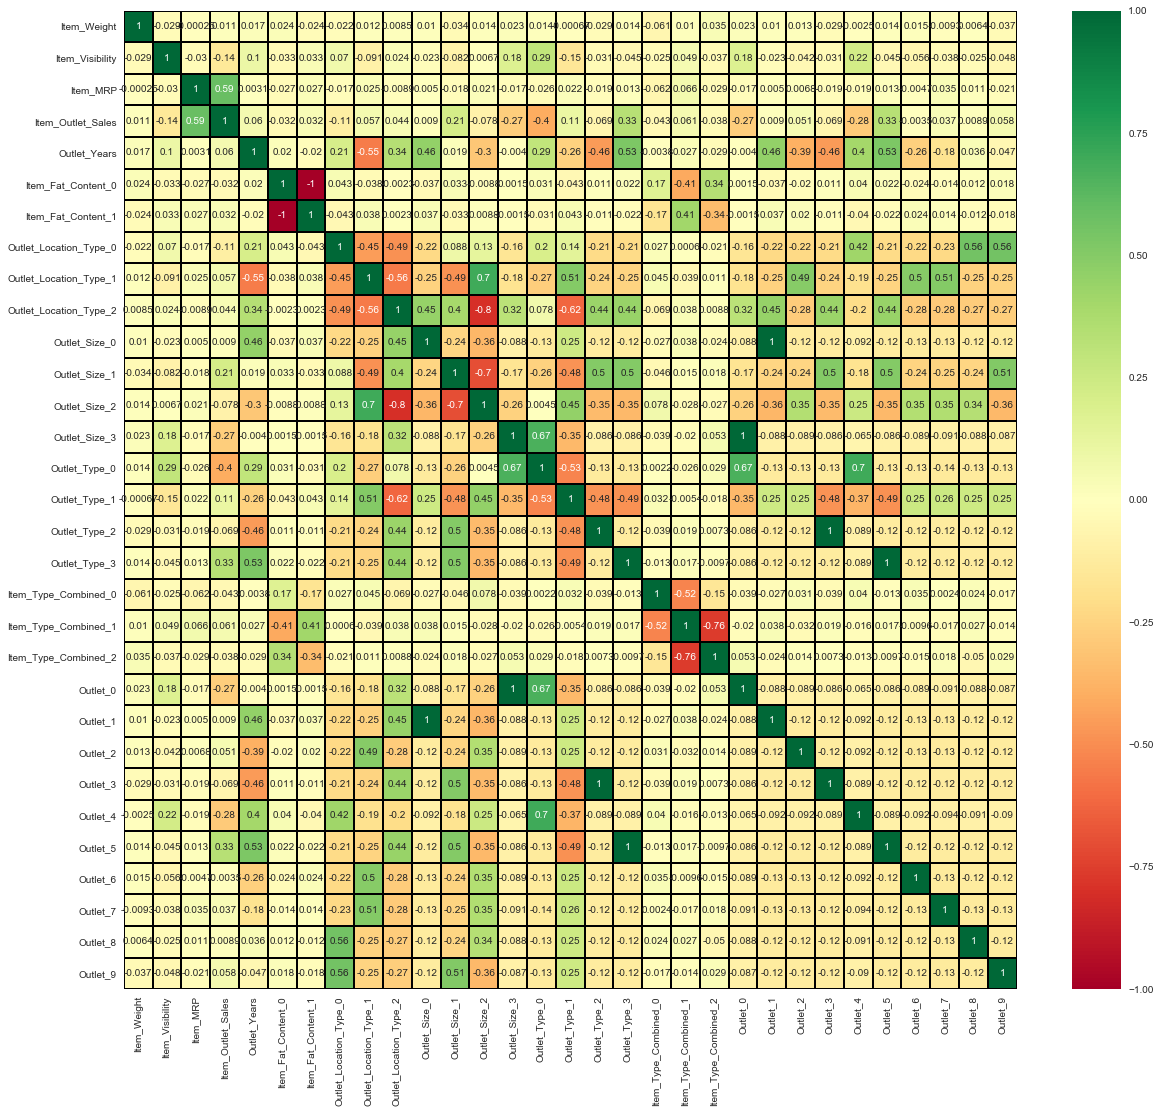

In [172]:
plt.figure(figsize=(20,18))
#matrix = np.triu(df_main.corr())
p=sns.heatmap(df_main.corr(), annot=True,cmap= 'RdYlGn',linewidths=1, linecolor='black')

## Data Prep 

#### Final Data for modeling

In [173]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Years',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Size_3', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3',
       'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2',
       'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5',
       'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9'],
      dtype='object')

In [174]:
df.drop(columns=["Item_Identifier","Outlet_Identifier"],inplace=True)

In [175]:
X = df_main.drop(["Item_Identifier","Outlet_Identifier","Item_Outlet_Sales"],axis=1)
y = df_main["Item_Outlet_Sales"]

In [176]:
X.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Outlet_Size_3,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,9.30,0.016047,249.8092,10,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,5.92,0.019278,48.2692,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,17.50,0.016760,141.6180,10,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,19.20,0.017834,182.0950,11,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,8.93,0.009780,53.8614,22,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


In [177]:
y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

## Model

In [178]:
import sklearn
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y,test_size=1 / 3,random_state=0)                                                                                                                                                                                     

### Linear Regression

In [179]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [180]:
reg.score(x_train,y_train)

0.5829014005926508

In [181]:
reg.score(x_test,y_test)

0.5745067008281586

### Ridge Regression

In [182]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [183]:
from sklearn.preprocessing import PolynomialFeatures
poly= PolynomialFeatures(2)
x_tr=poly.fit_transform(x_train)
x_te=poly.transform(x_test)

In [184]:
(x_train.shape,x_tr.shape)

((3336, 30), (3336, 496))

In [185]:
from sklearn.linear_model import RidgeCV
reg=RidgeCV(cv=5,scoring='neg_mean_absolute_error')
reg.fit(x_tr,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring='neg_mean_absolute_error',
        store_cv_values=False)

In [186]:
reg.score(x_tr,y_train)

0.6339190443896361

In [187]:
reg.score(x_te,y_test)

0.6268405557416854

### Random forest

In [188]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor()

estimator.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [189]:
estimator.score(x_train,y_train)

0.9812404321011248

In [190]:
estimator.score(x_test,y_test)

0.8511053626725205

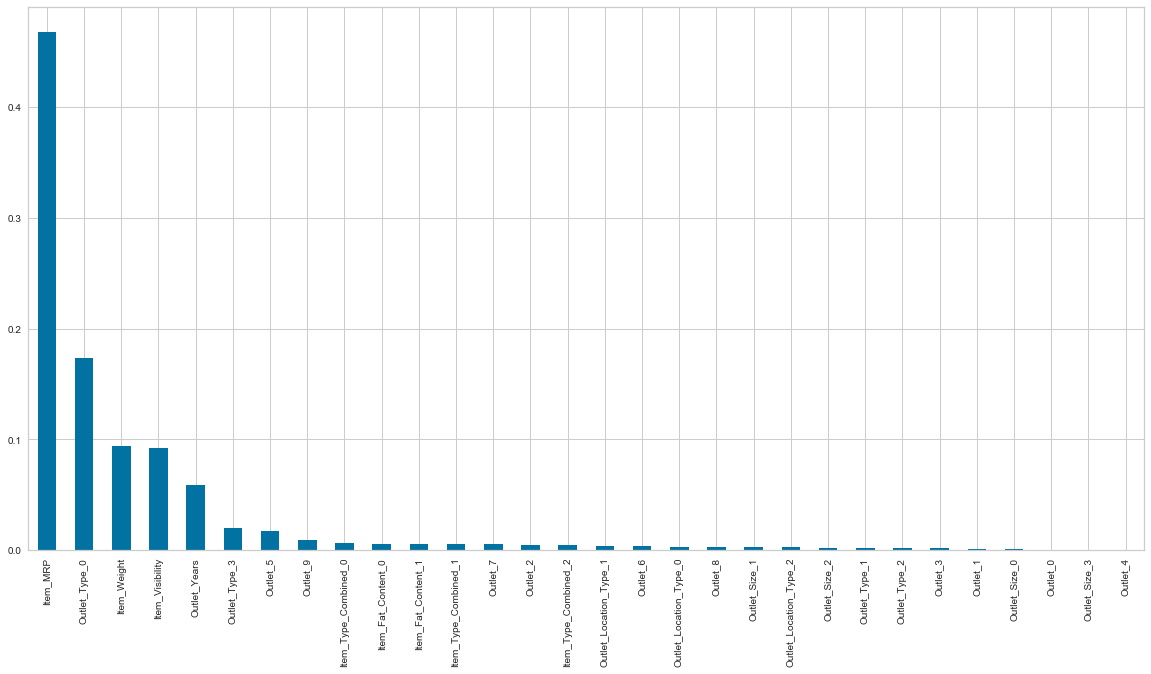

In [191]:
p=pd.Series(estimator.feature_importances_,X.columns).sort_values(ascending=False).plot(kind='bar',figsize=(20,10))

### Hyperparameter tuning using Grid Search

In [235]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor

model_params = {
    'Linear_reg': {
        'model': LinearRegression(),
        'params' : {
                'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]

            }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {"n_estimators": [10, 50, 100, 130],
                     'criterion':['mse'],
                        "max_depth": [None,2,3,4],
                       "max_features": ['auto', 'log2']
                       }
    },
    'ExtraTree_reg' : {
        'model': ExtraTreesRegressor(),
        'params': {"n_estimators": [10, 50, 100, 130],
                     'criterion':['mse'],
                        "max_depth": [None,2,3,4],
                       "max_features": ['auto', 'log2']
                    }
    },
     'CatBoost_reg':
        {
         'model':CatBoostRegressor(),
         'params':{"n_estimators": [130,200],
                     'loss_function':['RMSE','MAE'],
                   'learning_rate':[0.01,0.5,1]
                  
                      
                    }
        }
    
    }


In [236]:
scores = []

for model_name, mp in model_params.items():
    reg =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    reg.fit(x_train, y_train)
    scores.append({
        'model name' :model_name,
        'model': reg.best_estimator_,
        'best_score': reg.best_score_,
        'best_params': reg.best_params_,
        'R2_score' : sklearn.metrics.r2_score( y_test,reg.best_estimator_.predict(x_test))
    })
    
df1 = pd.DataFrame(scores,columns=['model name','model','best_score','best_params','R2_score'])


0:	learn: 1722.6568390	total: 4.4ms	remaining: 567ms
1:	learn: 1713.2948690	total: 9.56ms	remaining: 612ms
2:	learn: 1704.2264131	total: 13.8ms	remaining: 586ms
3:	learn: 1694.9734443	total: 17.2ms	remaining: 543ms
4:	learn: 1686.4903392	total: 23.2ms	remaining: 581ms
5:	learn: 1677.1368405	total: 26.9ms	remaining: 556ms
6:	learn: 1668.0450769	total: 30.3ms	remaining: 532ms
7:	learn: 1659.3933747	total: 34.8ms	remaining: 531ms
8:	learn: 1650.4958581	total: 39.7ms	remaining: 534ms
9:	learn: 1642.2307188	total: 42.2ms	remaining: 506ms
10:	learn: 1633.9016115	total: 45.6ms	remaining: 493ms
11:	learn: 1626.0123336	total: 50.1ms	remaining: 493ms
12:	learn: 1617.4378132	total: 53.6ms	remaining: 482ms
13:	learn: 1608.9231538	total: 57ms	remaining: 473ms
14:	learn: 1600.7772872	total: 60.4ms	remaining: 463ms
15:	learn: 1592.8590533	total: 64.8ms	remaining: 462ms
16:	learn: 1585.2890346	total: 68.4ms	remaining: 455ms
17:	learn: 1577.1953829	total: 71.8ms	remaining: 447ms
18:	learn: 1570.0752771

36:	learn: 1471.0318165	total: 179ms	remaining: 449ms
37:	learn: 1464.9464195	total: 184ms	remaining: 446ms
38:	learn: 1459.5379595	total: 190ms	remaining: 443ms
39:	learn: 1453.6744576	total: 198ms	remaining: 446ms
40:	learn: 1448.1591066	total: 203ms	remaining: 441ms
41:	learn: 1442.1481428	total: 208ms	remaining: 435ms
42:	learn: 1436.7300563	total: 214ms	remaining: 432ms
43:	learn: 1430.9391497	total: 219ms	remaining: 427ms
44:	learn: 1425.4376562	total: 222ms	remaining: 419ms
45:	learn: 1420.0871966	total: 226ms	remaining: 413ms
46:	learn: 1415.0107711	total: 230ms	remaining: 407ms
47:	learn: 1410.6230005	total: 233ms	remaining: 399ms
48:	learn: 1405.3370068	total: 237ms	remaining: 391ms
49:	learn: 1400.4159761	total: 241ms	remaining: 385ms
50:	learn: 1395.7494386	total: 245ms	remaining: 379ms
51:	learn: 1390.8618424	total: 248ms	remaining: 372ms
52:	learn: 1386.0896034	total: 251ms	remaining: 365ms
53:	learn: 1381.1050725	total: 255ms	remaining: 359ms
54:	learn: 1376.3322817	tota

75:	learn: 1268.9052377	total: 345ms	remaining: 245ms
76:	learn: 1265.1857358	total: 361ms	remaining: 249ms
77:	learn: 1262.1138597	total: 367ms	remaining: 244ms
78:	learn: 1258.7347538	total: 374ms	remaining: 241ms
79:	learn: 1255.2690193	total: 377ms	remaining: 236ms
80:	learn: 1252.0889972	total: 383ms	remaining: 232ms
81:	learn: 1248.7518193	total: 388ms	remaining: 227ms
82:	learn: 1245.3454704	total: 391ms	remaining: 222ms
83:	learn: 1242.1514883	total: 395ms	remaining: 216ms
84:	learn: 1239.2805187	total: 399ms	remaining: 211ms
85:	learn: 1236.1778983	total: 403ms	remaining: 206ms
86:	learn: 1233.1160809	total: 406ms	remaining: 201ms
87:	learn: 1230.3010257	total: 410ms	remaining: 195ms
88:	learn: 1227.3079041	total: 414ms	remaining: 191ms
89:	learn: 1224.3830877	total: 418ms	remaining: 186ms
90:	learn: 1222.1250229	total: 421ms	remaining: 180ms
91:	learn: 1219.6092109	total: 424ms	remaining: 175ms
92:	learn: 1216.8822604	total: 427ms	remaining: 170ms
93:	learn: 1214.3367362	tota

112:	learn: 1171.2487035	total: 510ms	remaining: 76.7ms
113:	learn: 1169.2846576	total: 514ms	remaining: 72.2ms
114:	learn: 1167.2448305	total: 519ms	remaining: 67.7ms
115:	learn: 1165.4456799	total: 524ms	remaining: 63.3ms
116:	learn: 1163.3449956	total: 529ms	remaining: 58.8ms
117:	learn: 1161.5530199	total: 534ms	remaining: 54.3ms
118:	learn: 1159.6459452	total: 558ms	remaining: 51.5ms
119:	learn: 1157.9345794	total: 562ms	remaining: 46.8ms
120:	learn: 1156.1293986	total: 566ms	remaining: 42.1ms
121:	learn: 1154.2021434	total: 571ms	remaining: 37.4ms
122:	learn: 1152.4731299	total: 576ms	remaining: 32.8ms
123:	learn: 1150.5588170	total: 580ms	remaining: 28ms
124:	learn: 1148.7534117	total: 584ms	remaining: 23.4ms
125:	learn: 1146.9878016	total: 588ms	remaining: 18.7ms
126:	learn: 1145.5022884	total: 591ms	remaining: 14ms
127:	learn: 1143.8828974	total: 599ms	remaining: 9.36ms
128:	learn: 1142.2465020	total: 602ms	remaining: 4.67ms
129:	learn: 1140.7712569	total: 606ms	remaining: 0us

38:	learn: 1440.5531811	total: 167ms	remaining: 689ms
39:	learn: 1434.6858180	total: 173ms	remaining: 691ms
40:	learn: 1429.2899321	total: 176ms	remaining: 683ms
41:	learn: 1423.7312545	total: 180ms	remaining: 679ms
42:	learn: 1418.3367803	total: 186ms	remaining: 680ms
43:	learn: 1413.1478550	total: 202ms	remaining: 716ms
44:	learn: 1407.8186172	total: 217ms	remaining: 747ms
45:	learn: 1402.2846688	total: 223ms	remaining: 746ms
46:	learn: 1396.7135316	total: 227ms	remaining: 738ms
47:	learn: 1391.8435630	total: 232ms	remaining: 735ms
48:	learn: 1386.8992647	total: 236ms	remaining: 727ms
49:	learn: 1381.8236036	total: 243ms	remaining: 728ms
50:	learn: 1376.7734345	total: 248ms	remaining: 725ms
51:	learn: 1372.1512056	total: 252ms	remaining: 718ms
52:	learn: 1367.0589515	total: 257ms	remaining: 712ms
53:	learn: 1362.1508010	total: 263ms	remaining: 711ms
54:	learn: 1357.8106618	total: 267ms	remaining: 704ms
55:	learn: 1353.2600026	total: 273ms	remaining: 703ms
56:	learn: 1348.6279239	tota

0:	learn: 1745.2207186	total: 5.25ms	remaining: 1.04s
1:	learn: 1735.6254677	total: 11ms	remaining: 1.09s
2:	learn: 1726.2209308	total: 14.7ms	remaining: 962ms
3:	learn: 1716.6389044	total: 20.1ms	remaining: 986ms
4:	learn: 1708.2973217	total: 26.2ms	remaining: 1.02s
5:	learn: 1698.7293533	total: 30.1ms	remaining: 973ms
6:	learn: 1689.7059925	total: 34.1ms	remaining: 941ms
7:	learn: 1681.6016040	total: 39.1ms	remaining: 937ms
8:	learn: 1672.6222288	total: 42.8ms	remaining: 909ms
9:	learn: 1663.8103868	total: 46.4ms	remaining: 881ms
10:	learn: 1655.3648593	total: 51.2ms	remaining: 879ms
11:	learn: 1646.9959589	total: 55.9ms	remaining: 875ms
12:	learn: 1638.4558499	total: 59.9ms	remaining: 861ms
13:	learn: 1629.9286615	total: 63.5ms	remaining: 843ms
14:	learn: 1622.7867034	total: 66ms	remaining: 815ms
15:	learn: 1614.9576413	total: 69.9ms	remaining: 804ms
16:	learn: 1606.7222705	total: 73.8ms	remaining: 794ms
17:	learn: 1599.1227801	total: 77.8ms	remaining: 787ms
18:	learn: 1591.3585743	

172:	learn: 1107.8622334	total: 840ms	remaining: 131ms
173:	learn: 1106.9814774	total: 846ms	remaining: 126ms
174:	learn: 1106.0018337	total: 856ms	remaining: 122ms
175:	learn: 1104.7388990	total: 865ms	remaining: 118ms
176:	learn: 1104.0427866	total: 870ms	remaining: 113ms
177:	learn: 1103.2079976	total: 879ms	remaining: 109ms
178:	learn: 1102.1930331	total: 883ms	remaining: 104ms
179:	learn: 1101.2321685	total: 888ms	remaining: 98.7ms
180:	learn: 1100.2346889	total: 897ms	remaining: 94.2ms
181:	learn: 1099.4917317	total: 901ms	remaining: 89.1ms
182:	learn: 1098.7281443	total: 905ms	remaining: 84ms
183:	learn: 1097.9767820	total: 910ms	remaining: 79.2ms
184:	learn: 1096.8353628	total: 914ms	remaining: 74.1ms
185:	learn: 1096.2505774	total: 918ms	remaining: 69.1ms
186:	learn: 1095.6001969	total: 923ms	remaining: 64.2ms
187:	learn: 1094.9689344	total: 927ms	remaining: 59.2ms
188:	learn: 1094.0152756	total: 931ms	remaining: 54.2ms
189:	learn: 1093.3546800	total: 937ms	remaining: 49.3ms
1

139:	learn: 1126.0863245	total: 662ms	remaining: 284ms
140:	learn: 1124.5831602	total: 667ms	remaining: 279ms
141:	learn: 1123.3853585	total: 674ms	remaining: 275ms
142:	learn: 1121.9764982	total: 680ms	remaining: 271ms
143:	learn: 1120.7342619	total: 685ms	remaining: 266ms
144:	learn: 1119.5801900	total: 697ms	remaining: 264ms
145:	learn: 1118.3433931	total: 703ms	remaining: 260ms
146:	learn: 1116.9488055	total: 708ms	remaining: 255ms
147:	learn: 1115.6661007	total: 711ms	remaining: 250ms
148:	learn: 1114.3653818	total: 715ms	remaining: 245ms
149:	learn: 1113.2285274	total: 720ms	remaining: 240ms
150:	learn: 1111.9804640	total: 724ms	remaining: 235ms
151:	learn: 1111.0073100	total: 728ms	remaining: 230ms
152:	learn: 1110.0045437	total: 732ms	remaining: 225ms
153:	learn: 1108.6280447	total: 737ms	remaining: 220ms
154:	learn: 1107.5323467	total: 740ms	remaining: 215ms
155:	learn: 1106.3965698	total: 744ms	remaining: 210ms
156:	learn: 1105.2284985	total: 749ms	remaining: 205ms
157:	learn

104:	learn: 1187.1369980	total: 502ms	remaining: 454ms
105:	learn: 1184.9001439	total: 515ms	remaining: 457ms
106:	learn: 1182.7801617	total: 523ms	remaining: 455ms
107:	learn: 1180.3782904	total: 537ms	remaining: 458ms
108:	learn: 1178.2588445	total: 542ms	remaining: 452ms
109:	learn: 1176.4759185	total: 546ms	remaining: 447ms
110:	learn: 1174.5208704	total: 550ms	remaining: 441ms
111:	learn: 1172.9269899	total: 553ms	remaining: 434ms
112:	learn: 1171.2487035	total: 556ms	remaining: 428ms
113:	learn: 1169.2846576	total: 560ms	remaining: 423ms
114:	learn: 1167.2448305	total: 564ms	remaining: 417ms
115:	learn: 1165.4456799	total: 567ms	remaining: 411ms
116:	learn: 1163.3449956	total: 570ms	remaining: 405ms
117:	learn: 1161.5530199	total: 575ms	remaining: 399ms
118:	learn: 1159.6459452	total: 578ms	remaining: 393ms
119:	learn: 1157.9345794	total: 581ms	remaining: 387ms
120:	learn: 1156.1293986	total: 584ms	remaining: 381ms
121:	learn: 1154.2021434	total: 590ms	remaining: 378ms
122:	learn

69:	learn: 1290.1281226	total: 331ms	remaining: 614ms
70:	learn: 1286.5502545	total: 346ms	remaining: 628ms
71:	learn: 1283.0792650	total: 353ms	remaining: 627ms
72:	learn: 1279.6092055	total: 358ms	remaining: 622ms
73:	learn: 1276.1145820	total: 362ms	remaining: 616ms
74:	learn: 1272.5414901	total: 371ms	remaining: 618ms
75:	learn: 1269.2683204	total: 375ms	remaining: 611ms
76:	learn: 1265.8104297	total: 379ms	remaining: 605ms
77:	learn: 1262.5080994	total: 384ms	remaining: 601ms
78:	learn: 1259.4420567	total: 389ms	remaining: 595ms
79:	learn: 1256.0565275	total: 393ms	remaining: 590ms
80:	learn: 1252.8071993	total: 400ms	remaining: 587ms
81:	learn: 1249.7199393	total: 404ms	remaining: 581ms
82:	learn: 1246.7902431	total: 407ms	remaining: 574ms
83:	learn: 1243.6783173	total: 413ms	remaining: 571ms
84:	learn: 1240.6132122	total: 418ms	remaining: 565ms
85:	learn: 1237.6611004	total: 422ms	remaining: 559ms
86:	learn: 1234.9714069	total: 428ms	remaining: 555ms
87:	learn: 1232.0131801	tota

35:	learn: 1123.4456697	total: 184ms	remaining: 480ms
36:	learn: 1118.5908406	total: 194ms	remaining: 488ms
37:	learn: 1113.2546952	total: 199ms	remaining: 482ms
38:	learn: 1108.1845419	total: 204ms	remaining: 477ms
39:	learn: 1103.3563288	total: 211ms	remaining: 475ms
40:	learn: 1098.2381264	total: 217ms	remaining: 471ms
41:	learn: 1093.9877058	total: 222ms	remaining: 465ms
42:	learn: 1089.4882805	total: 226ms	remaining: 458ms
43:	learn: 1084.8711234	total: 230ms	remaining: 450ms
44:	learn: 1081.0484216	total: 234ms	remaining: 442ms
45:	learn: 1076.4221084	total: 240ms	remaining: 439ms
46:	learn: 1071.6367611	total: 244ms	remaining: 431ms
47:	learn: 1067.3003538	total: 250ms	remaining: 426ms
48:	learn: 1063.2684002	total: 256ms	remaining: 422ms
49:	learn: 1058.6902554	total: 259ms	remaining: 415ms
50:	learn: 1055.2896505	total: 263ms	remaining: 407ms
51:	learn: 1051.1155644	total: 267ms	remaining: 401ms
52:	learn: 1047.5830259	total: 271ms	remaining: 394ms
53:	learn: 1043.4305113	tota

63:	learn: 1021.4535613	total: 337ms	remaining: 347ms
64:	learn: 1017.9138626	total: 345ms	remaining: 345ms
65:	learn: 1014.6269141	total: 350ms	remaining: 339ms
66:	learn: 1010.9497903	total: 356ms	remaining: 335ms
67:	learn: 1007.8949171	total: 361ms	remaining: 329ms
68:	learn: 1005.0443635	total: 374ms	remaining: 331ms
69:	learn: 1001.4279709	total: 378ms	remaining: 324ms
70:	learn: 997.7069400	total: 383ms	remaining: 318ms
71:	learn: 994.7379153	total: 389ms	remaining: 313ms
72:	learn: 991.2483350	total: 394ms	remaining: 308ms
73:	learn: 988.0643461	total: 399ms	remaining: 302ms
74:	learn: 984.4930287	total: 408ms	remaining: 299ms
75:	learn: 981.8407490	total: 413ms	remaining: 293ms
76:	learn: 978.5157453	total: 421ms	remaining: 290ms
77:	learn: 975.3507484	total: 425ms	remaining: 283ms
78:	learn: 972.0194646	total: 430ms	remaining: 277ms
79:	learn: 968.9220456	total: 434ms	remaining: 271ms
80:	learn: 965.8830625	total: 439ms	remaining: 266ms
81:	learn: 962.7484559	total: 444ms	rem

93:	learn: 909.9760202	total: 528ms	remaining: 202ms
94:	learn: 907.6924724	total: 534ms	remaining: 197ms
95:	learn: 905.2488665	total: 539ms	remaining: 191ms
96:	learn: 903.0710009	total: 545ms	remaining: 185ms
97:	learn: 901.3855470	total: 547ms	remaining: 179ms
98:	learn: 899.3185450	total: 558ms	remaining: 175ms
99:	learn: 897.2777541	total: 567ms	remaining: 170ms
100:	learn: 895.2478810	total: 574ms	remaining: 165ms
101:	learn: 893.2098143	total: 579ms	remaining: 159ms
102:	learn: 891.3569006	total: 584ms	remaining: 153ms
103:	learn: 889.6564341	total: 590ms	remaining: 148ms
104:	learn: 887.6620623	total: 596ms	remaining: 142ms
105:	learn: 885.3615566	total: 602ms	remaining: 136ms
106:	learn: 883.9538526	total: 605ms	remaining: 130ms
107:	learn: 881.9345154	total: 610ms	remaining: 124ms
108:	learn: 879.9996874	total: 614ms	remaining: 118ms
109:	learn: 878.0359123	total: 620ms	remaining: 113ms
110:	learn: 876.0065225	total: 624ms	remaining: 107ms
111:	learn: 874.5170125	total: 629m

122:	learn: 861.0153367	total: 684ms	remaining: 38.9ms
123:	learn: 859.4163802	total: 688ms	remaining: 33.3ms
124:	learn: 857.3504175	total: 699ms	remaining: 28ms
125:	learn: 855.7337017	total: 705ms	remaining: 22.4ms
126:	learn: 853.7589138	total: 711ms	remaining: 16.8ms
127:	learn: 852.4479764	total: 717ms	remaining: 11.2ms
128:	learn: 850.5815928	total: 722ms	remaining: 5.59ms
129:	learn: 848.7786613	total: 727ms	remaining: 0us
0:	learn: 1322.7437636	total: 8.4ms	remaining: 1.08s
1:	learn: 1315.5843742	total: 14.9ms	remaining: 952ms
2:	learn: 1308.3593476	total: 19.2ms	remaining: 811ms
3:	learn: 1300.9873277	total: 23.5ms	remaining: 741ms
4:	learn: 1292.8756817	total: 29.8ms	remaining: 745ms
5:	learn: 1287.0869317	total: 32.3ms	remaining: 668ms
6:	learn: 1280.3923743	total: 36.6ms	remaining: 644ms
7:	learn: 1273.4786336	total: 42.8ms	remaining: 653ms
8:	learn: 1266.0979287	total: 47.8ms	remaining: 643ms
9:	learn: 1259.1286882	total: 52.8ms	remaining: 634ms
10:	learn: 1252.8631662	to

33:	learn: 1134.1954238	total: 170ms	remaining: 831ms
34:	learn: 1128.7764146	total: 176ms	remaining: 830ms
35:	learn: 1123.4456697	total: 181ms	remaining: 826ms
36:	learn: 1118.5908406	total: 188ms	remaining: 826ms
37:	learn: 1113.2546952	total: 193ms	remaining: 822ms
38:	learn: 1108.1845419	total: 198ms	remaining: 817ms
39:	learn: 1103.3563288	total: 203ms	remaining: 814ms
40:	learn: 1098.2381264	total: 212ms	remaining: 824ms
41:	learn: 1093.9877058	total: 219ms	remaining: 823ms
42:	learn: 1089.4882805	total: 223ms	remaining: 814ms
43:	learn: 1084.8711234	total: 228ms	remaining: 810ms
44:	learn: 1081.0484216	total: 233ms	remaining: 804ms
45:	learn: 1076.4221084	total: 238ms	remaining: 796ms
46:	learn: 1071.6367611	total: 243ms	remaining: 791ms
47:	learn: 1067.3003538	total: 250ms	remaining: 791ms
48:	learn: 1063.2684002	total: 255ms	remaining: 784ms
49:	learn: 1058.6902554	total: 261ms	remaining: 782ms
50:	learn: 1055.2896505	total: 265ms	remaining: 774ms
51:	learn: 1051.1155644	tota

0:	learn: 1359.5767778	total: 6.22ms	remaining: 1.24s
1:	learn: 1352.0670280	total: 10.1ms	remaining: 1s
2:	learn: 1344.7065533	total: 14.3ms	remaining: 942ms
3:	learn: 1337.0749190	total: 19.5ms	remaining: 955ms
4:	learn: 1329.2431405	total: 23.4ms	remaining: 914ms
5:	learn: 1323.5580971	total: 25.9ms	remaining: 836ms
6:	learn: 1316.4899949	total: 30.7ms	remaining: 847ms
7:	learn: 1308.9883766	total: 35.7ms	remaining: 856ms
8:	learn: 1301.2968972	total: 39.9ms	remaining: 847ms
9:	learn: 1294.0252804	total: 45.8ms	remaining: 871ms
10:	learn: 1287.0786796	total: 51.9ms	remaining: 891ms
11:	learn: 1280.1686791	total: 56.4ms	remaining: 884ms
12:	learn: 1273.1484932	total: 62.9ms	remaining: 905ms
13:	learn: 1266.7741359	total: 68.5ms	remaining: 911ms
14:	learn: 1260.3543693	total: 73.8ms	remaining: 910ms
15:	learn: 1253.9102402	total: 79.8ms	remaining: 918ms
16:	learn: 1247.9835755	total: 86.1ms	remaining: 927ms
17:	learn: 1241.2181834	total: 95.4ms	remaining: 964ms
18:	learn: 1234.4177297

181:	learn: 806.0683748	total: 1.01s	remaining: 99.7ms
182:	learn: 805.0389331	total: 1.02s	remaining: 94.4ms
183:	learn: 804.3324572	total: 1.02s	remaining: 89ms
184:	learn: 803.6724369	total: 1.03s	remaining: 83.7ms
185:	learn: 803.0942324	total: 1.04s	remaining: 78.6ms
186:	learn: 802.1927089	total: 1.05s	remaining: 73.1ms
187:	learn: 801.3415455	total: 1.06s	remaining: 67.4ms
188:	learn: 800.6555088	total: 1.06s	remaining: 61.8ms
189:	learn: 800.1998295	total: 1.06s	remaining: 56.1ms
190:	learn: 799.4532276	total: 1.07s	remaining: 50.4ms
191:	learn: 798.5048507	total: 1.08s	remaining: 44.9ms
192:	learn: 797.6585182	total: 1.08s	remaining: 39.3ms
193:	learn: 796.8737821	total: 1.09s	remaining: 33.6ms
194:	learn: 795.9295362	total: 1.09s	remaining: 28ms
195:	learn: 795.4340854	total: 1.1s	remaining: 22.4ms
196:	learn: 794.6555392	total: 1.1s	remaining: 16.8ms
197:	learn: 793.9536603	total: 1.11s	remaining: 11.2ms
198:	learn: 793.2074801	total: 1.11s	remaining: 5.58ms
199:	learn: 792.

159:	learn: 807.7856201	total: 856ms	remaining: 214ms
160:	learn: 806.9566878	total: 868ms	remaining: 210ms
161:	learn: 805.9011164	total: 883ms	remaining: 207ms
162:	learn: 804.8733125	total: 888ms	remaining: 202ms
163:	learn: 804.1664376	total: 894ms	remaining: 196ms
164:	learn: 803.1680427	total: 901ms	remaining: 191ms
165:	learn: 801.9667021	total: 906ms	remaining: 186ms
166:	learn: 801.0889387	total: 911ms	remaining: 180ms
167:	learn: 800.2604448	total: 916ms	remaining: 174ms
168:	learn: 799.0462526	total: 923ms	remaining: 169ms
169:	learn: 798.1224676	total: 928ms	remaining: 164ms
170:	learn: 797.3222681	total: 933ms	remaining: 158ms
171:	learn: 796.6019128	total: 939ms	remaining: 153ms
172:	learn: 795.6059899	total: 943ms	remaining: 147ms
173:	learn: 794.7875987	total: 948ms	remaining: 142ms
174:	learn: 794.0713420	total: 953ms	remaining: 136ms
175:	learn: 793.3055324	total: 957ms	remaining: 131ms
176:	learn: 792.3866022	total: 962ms	remaining: 125ms
177:	learn: 791.7097419	tota

129:	learn: 848.7786613	total: 683ms	remaining: 368ms
130:	learn: 847.4467840	total: 691ms	remaining: 364ms
131:	learn: 845.7937537	total: 698ms	remaining: 360ms
132:	learn: 844.3109552	total: 710ms	remaining: 357ms
133:	learn: 842.6886297	total: 716ms	remaining: 353ms
134:	learn: 841.3306932	total: 725ms	remaining: 349ms
135:	learn: 840.0406099	total: 731ms	remaining: 344ms
136:	learn: 838.9421752	total: 734ms	remaining: 338ms
137:	learn: 837.3527620	total: 741ms	remaining: 333ms
138:	learn: 835.8706961	total: 747ms	remaining: 328ms
139:	learn: 834.5171357	total: 751ms	remaining: 322ms
140:	learn: 833.1296008	total: 756ms	remaining: 316ms
141:	learn: 831.8768460	total: 762ms	remaining: 311ms
142:	learn: 830.3495272	total: 766ms	remaining: 305ms
143:	learn: 828.9749477	total: 775ms	remaining: 302ms
144:	learn: 827.5515713	total: 780ms	remaining: 296ms
145:	learn: 826.6079478	total: 783ms	remaining: 290ms
146:	learn: 825.1480299	total: 789ms	remaining: 284ms
147:	learn: 824.1321751	tota

95:	learn: 907.8454631	total: 521ms	remaining: 564ms
96:	learn: 905.4655624	total: 531ms	remaining: 564ms
97:	learn: 903.0515593	total: 539ms	remaining: 561ms
98:	learn: 901.3529462	total: 547ms	remaining: 558ms
99:	learn: 899.1471274	total: 558ms	remaining: 558ms
100:	learn: 896.6851728	total: 564ms	remaining: 553ms
101:	learn: 894.5555388	total: 569ms	remaining: 546ms
102:	learn: 892.5995127	total: 576ms	remaining: 542ms
103:	learn: 890.8269641	total: 582ms	remaining: 537ms
104:	learn: 888.5387200	total: 589ms	remaining: 533ms
105:	learn: 886.3111485	total: 594ms	remaining: 526ms
106:	learn: 884.7702640	total: 598ms	remaining: 520ms
107:	learn: 883.3833666	total: 605ms	remaining: 516ms
108:	learn: 881.1467470	total: 609ms	remaining: 509ms
109:	learn: 879.2921502	total: 614ms	remaining: 503ms
110:	learn: 877.5327439	total: 620ms	remaining: 497ms
111:	learn: 876.1866476	total: 624ms	remaining: 490ms
112:	learn: 874.9917699	total: 627ms	remaining: 483ms
113:	learn: 872.8794706	total: 63

69:	learn: 571.1647952	total: 339ms	remaining: 290ms
70:	learn: 568.0615588	total: 348ms	remaining: 290ms
71:	learn: 563.3819502	total: 353ms	remaining: 284ms
72:	learn: 562.1825603	total: 362ms	remaining: 283ms
73:	learn: 557.5569519	total: 367ms	remaining: 277ms
74:	learn: 555.8828796	total: 379ms	remaining: 278ms
75:	learn: 550.5174820	total: 383ms	remaining: 272ms
76:	learn: 543.7016554	total: 389ms	remaining: 268ms
77:	learn: 539.5269350	total: 392ms	remaining: 262ms
78:	learn: 537.5802108	total: 396ms	remaining: 256ms
79:	learn: 533.0292392	total: 402ms	remaining: 251ms
80:	learn: 529.4039149	total: 411ms	remaining: 248ms
81:	learn: 523.8240117	total: 423ms	remaining: 247ms
82:	learn: 521.0560971	total: 426ms	remaining: 241ms
83:	learn: 516.7403062	total: 431ms	remaining: 236ms
84:	learn: 514.7272757	total: 436ms	remaining: 231ms
85:	learn: 509.0454545	total: 440ms	remaining: 225ms
86:	learn: 506.9383031	total: 447ms	remaining: 221ms
87:	learn: 504.8438790	total: 452ms	remaining:

102:	learn: 474.7345792	total: 515ms	remaining: 135ms
103:	learn: 472.3072236	total: 527ms	remaining: 132ms
104:	learn: 469.8500051	total: 533ms	remaining: 127ms
105:	learn: 467.2627163	total: 540ms	remaining: 122ms
106:	learn: 465.9687514	total: 544ms	remaining: 117ms
107:	learn: 465.0529651	total: 554ms	remaining: 113ms
108:	learn: 462.8755571	total: 565ms	remaining: 109ms
109:	learn: 459.9493075	total: 568ms	remaining: 103ms
110:	learn: 458.4641278	total: 572ms	remaining: 97.9ms
111:	learn: 456.9675153	total: 578ms	remaining: 92.8ms
112:	learn: 454.1725037	total: 583ms	remaining: 87.7ms
113:	learn: 451.0562565	total: 587ms	remaining: 82.3ms
114:	learn: 450.0025305	total: 592ms	remaining: 77.2ms
115:	learn: 448.7647494	total: 597ms	remaining: 72.1ms
116:	learn: 445.8095392	total: 602ms	remaining: 66.8ms
117:	learn: 442.2071906	total: 606ms	remaining: 61.6ms
118:	learn: 440.9439334	total: 610ms	remaining: 56.4ms
119:	learn: 438.6048027	total: 614ms	remaining: 51.1ms
120:	learn: 436.41

0:	learn: 1342.0587494	total: 13.3ms	remaining: 1.72s
1:	learn: 1147.3487178	total: 20.7ms	remaining: 1.32s
2:	learn: 1087.1403221	total: 24.6ms	remaining: 1.04s
3:	learn: 1052.7477099	total: 28.5ms	remaining: 899ms
4:	learn: 1020.6663170	total: 34.7ms	remaining: 868ms
5:	learn: 999.5693052	total: 39.2ms	remaining: 810ms
6:	learn: 976.1205238	total: 43.5ms	remaining: 765ms
7:	learn: 963.2152000	total: 50.9ms	remaining: 777ms
8:	learn: 946.1499179	total: 55.6ms	remaining: 747ms
9:	learn: 942.3060021	total: 59.6ms	remaining: 715ms
10:	learn: 936.6355162	total: 64.7ms	remaining: 700ms
11:	learn: 926.3071174	total: 70ms	remaining: 688ms
12:	learn: 914.4502619	total: 73.7ms	remaining: 663ms
13:	learn: 906.6261343	total: 80.2ms	remaining: 664ms
14:	learn: 899.7137015	total: 84.1ms	remaining: 645ms
15:	learn: 890.8425565	total: 88.4ms	remaining: 630ms
16:	learn: 880.4111000	total: 92.5ms	remaining: 615ms
17:	learn: 872.1698894	total: 97.6ms	remaining: 607ms
18:	learn: 867.1772808	total: 101ms

38:	learn: 717.2162522	total: 181ms	remaining: 422ms
39:	learn: 711.7842161	total: 188ms	remaining: 422ms
40:	learn: 706.9197683	total: 193ms	remaining: 420ms
41:	learn: 702.1441353	total: 201ms	remaining: 421ms
42:	learn: 698.4735813	total: 207ms	remaining: 419ms
43:	learn: 694.3877607	total: 222ms	remaining: 434ms
44:	learn: 689.1049262	total: 228ms	remaining: 430ms
45:	learn: 683.0751101	total: 232ms	remaining: 423ms
46:	learn: 679.1572454	total: 236ms	remaining: 416ms
47:	learn: 675.6880550	total: 241ms	remaining: 411ms
48:	learn: 669.6784508	total: 246ms	remaining: 407ms
49:	learn: 665.7929287	total: 250ms	remaining: 400ms
50:	learn: 658.2838418	total: 256ms	remaining: 396ms
51:	learn: 651.8170211	total: 261ms	remaining: 391ms
52:	learn: 643.6395366	total: 265ms	remaining: 385ms
53:	learn: 640.6720289	total: 269ms	remaining: 378ms
54:	learn: 634.8497920	total: 274ms	remaining: 374ms
55:	learn: 630.0327986	total: 278ms	remaining: 367ms
56:	learn: 626.6711889	total: 282ms	remaining:

69:	learn: 571.1647952	total: 338ms	remaining: 628ms
70:	learn: 568.0615588	total: 349ms	remaining: 634ms
71:	learn: 563.3819502	total: 354ms	remaining: 630ms
72:	learn: 562.1825603	total: 363ms	remaining: 631ms
73:	learn: 557.5569519	total: 367ms	remaining: 625ms
74:	learn: 555.8828796	total: 376ms	remaining: 626ms
75:	learn: 550.5174820	total: 380ms	remaining: 620ms
76:	learn: 543.7016554	total: 384ms	remaining: 614ms
77:	learn: 539.5269350	total: 388ms	remaining: 607ms
78:	learn: 537.5802108	total: 393ms	remaining: 602ms
79:	learn: 533.0292392	total: 396ms	remaining: 594ms
80:	learn: 529.4039149	total: 400ms	remaining: 587ms
81:	learn: 523.8240117	total: 405ms	remaining: 583ms
82:	learn: 521.0560971	total: 409ms	remaining: 576ms
83:	learn: 516.7403062	total: 415ms	remaining: 572ms
84:	learn: 514.7272757	total: 420ms	remaining: 568ms
85:	learn: 509.0454545	total: 423ms	remaining: 561ms
86:	learn: 506.9383031	total: 427ms	remaining: 555ms
87:	learn: 504.8438790	total: 430ms	remaining:

32:	learn: 740.6552941	total: 175ms	remaining: 883ms
33:	learn: 735.0056768	total: 179ms	remaining: 875ms
34:	learn: 725.8991743	total: 184ms	remaining: 869ms
35:	learn: 720.7064061	total: 190ms	remaining: 867ms
36:	learn: 716.3299147	total: 195ms	remaining: 858ms
37:	learn: 710.5222700	total: 200ms	remaining: 853ms
38:	learn: 703.0333073	total: 207ms	remaining: 856ms
39:	learn: 697.0469610	total: 213ms	remaining: 852ms
40:	learn: 688.5544913	total: 219ms	remaining: 849ms
41:	learn: 684.9599432	total: 225ms	remaining: 848ms
42:	learn: 680.0730246	total: 231ms	remaining: 842ms
43:	learn: 675.3069113	total: 235ms	remaining: 834ms
44:	learn: 671.3389287	total: 239ms	remaining: 822ms
45:	learn: 668.2125109	total: 243ms	remaining: 814ms
46:	learn: 662.4905881	total: 249ms	remaining: 810ms
47:	learn: 658.8787769	total: 253ms	remaining: 801ms
48:	learn: 654.3188611	total: 257ms	remaining: 793ms
49:	learn: 646.1028590	total: 269ms	remaining: 806ms
50:	learn: 639.6371801	total: 273ms	remaining:

0:	learn: 1335.2192377	total: 5.67ms	remaining: 1.13s
1:	learn: 1158.7644898	total: 10.3ms	remaining: 1.02s
2:	learn: 1088.1614338	total: 14.6ms	remaining: 957ms
3:	learn: 1059.7497958	total: 18.7ms	remaining: 915ms
4:	learn: 1038.5287946	total: 24ms	remaining: 936ms
5:	learn: 1021.9266572	total: 27.5ms	remaining: 891ms
6:	learn: 1005.1199133	total: 31.7ms	remaining: 875ms
7:	learn: 990.4275299	total: 36.5ms	remaining: 876ms
8:	learn: 982.6583459	total: 40.7ms	remaining: 864ms
9:	learn: 970.4473105	total: 45ms	remaining: 855ms
10:	learn: 959.7036808	total: 49.2ms	remaining: 846ms
11:	learn: 945.3804784	total: 57.9ms	remaining: 907ms
12:	learn: 932.3470842	total: 61.6ms	remaining: 887ms
13:	learn: 922.6908938	total: 66ms	remaining: 877ms
14:	learn: 919.0954526	total: 70.6ms	remaining: 871ms
15:	learn: 916.7112478	total: 74.6ms	remaining: 858ms
16:	learn: 898.5854297	total: 78.6ms	remaining: 846ms
17:	learn: 889.8892795	total: 83.6ms	remaining: 846ms
18:	learn: 878.4317009	total: 87.2ms	

165:	learn: 351.2767154	total: 834ms	remaining: 171ms
166:	learn: 350.4367329	total: 842ms	remaining: 166ms
167:	learn: 349.6261519	total: 847ms	remaining: 161ms
168:	learn: 348.3525785	total: 854ms	remaining: 157ms
169:	learn: 346.3071403	total: 860ms	remaining: 152ms
170:	learn: 345.4836266	total: 873ms	remaining: 148ms
171:	learn: 344.3823051	total: 877ms	remaining: 143ms
172:	learn: 343.5293035	total: 883ms	remaining: 138ms
173:	learn: 342.3066788	total: 887ms	remaining: 133ms
174:	learn: 340.2989172	total: 892ms	remaining: 127ms
175:	learn: 338.8781429	total: 899ms	remaining: 123ms
176:	learn: 336.7753013	total: 903ms	remaining: 117ms
177:	learn: 335.9811793	total: 909ms	remaining: 112ms
178:	learn: 335.3703239	total: 914ms	remaining: 107ms
179:	learn: 333.4367156	total: 918ms	remaining: 102ms
180:	learn: 332.1504616	total: 923ms	remaining: 96.8ms
181:	learn: 331.4267713	total: 928ms	remaining: 91.7ms
182:	learn: 329.5931196	total: 932ms	remaining: 86.6ms
183:	learn: 328.2722595	t

138:	learn: 400.3883146	total: 674ms	remaining: 296ms
139:	learn: 397.7157355	total: 681ms	remaining: 292ms
140:	learn: 396.8725715	total: 690ms	remaining: 289ms
141:	learn: 395.3325581	total: 700ms	remaining: 286ms
142:	learn: 391.8206116	total: 713ms	remaining: 284ms
143:	learn: 390.2654731	total: 717ms	remaining: 279ms
144:	learn: 389.1478886	total: 721ms	remaining: 273ms
145:	learn: 385.9462422	total: 727ms	remaining: 269ms
146:	learn: 384.4561242	total: 731ms	remaining: 264ms
147:	learn: 382.4182478	total: 735ms	remaining: 258ms
148:	learn: 379.5572182	total: 742ms	remaining: 254ms
149:	learn: 375.9903158	total: 746ms	remaining: 249ms
150:	learn: 374.9659535	total: 749ms	remaining: 243ms
151:	learn: 373.3760532	total: 754ms	remaining: 238ms
152:	learn: 371.8193956	total: 758ms	remaining: 233ms
153:	learn: 369.6371338	total: 762ms	remaining: 228ms
154:	learn: 367.7185612	total: 766ms	remaining: 222ms
155:	learn: 365.9521745	total: 772ms	remaining: 218ms
156:	learn: 364.9779238	tota

105:	learn: 459.7247819	total: 515ms	remaining: 457ms
106:	learn: 456.6906815	total: 525ms	remaining: 456ms
107:	learn: 454.6405300	total: 530ms	remaining: 451ms
108:	learn: 452.8324205	total: 534ms	remaining: 446ms
109:	learn: 450.9629709	total: 542ms	remaining: 443ms
110:	learn: 447.9896430	total: 546ms	remaining: 438ms
111:	learn: 444.4457365	total: 552ms	remaining: 434ms
112:	learn: 443.3875355	total: 558ms	remaining: 430ms
113:	learn: 441.4958657	total: 561ms	remaining: 424ms
114:	learn: 438.6475328	total: 565ms	remaining: 418ms
115:	learn: 437.4917127	total: 570ms	remaining: 413ms
116:	learn: 434.9755975	total: 574ms	remaining: 407ms
117:	learn: 433.0333962	total: 578ms	remaining: 402ms
118:	learn: 431.6095835	total: 584ms	remaining: 397ms
119:	learn: 430.7956094	total: 589ms	remaining: 392ms
120:	learn: 430.1543425	total: 593ms	remaining: 387ms
121:	learn: 428.1584791	total: 598ms	remaining: 382ms
122:	learn: 424.1231133	total: 602ms	remaining: 377ms
123:	learn: 422.5601012	tota

58:	learn: 524.5845324	total: 349ms	remaining: 420ms
59:	learn: 523.5728439	total: 356ms	remaining: 416ms
60:	learn: 523.3133409	total: 362ms	remaining: 409ms
61:	learn: 521.8971553	total: 368ms	remaining: 403ms
62:	learn: 521.1205525	total: 373ms	remaining: 397ms
63:	learn: 519.6769439	total: 383ms	remaining: 394ms
64:	learn: 516.0955791	total: 388ms	remaining: 388ms
65:	learn: 515.3577714	total: 393ms	remaining: 381ms
66:	learn: 514.4999861	total: 402ms	remaining: 378ms
67:	learn: 514.0005907	total: 406ms	remaining: 370ms
68:	learn: 511.2576931	total: 412ms	remaining: 364ms
69:	learn: 509.3962435	total: 418ms	remaining: 358ms
70:	learn: 507.9423396	total: 423ms	remaining: 351ms
71:	learn: 505.8160690	total: 429ms	remaining: 345ms
72:	learn: 505.0397381	total: 433ms	remaining: 338ms
73:	learn: 503.3910949	total: 438ms	remaining: 331ms
74:	learn: 501.9725953	total: 445ms	remaining: 326ms
75:	learn: 499.3554207	total: 451ms	remaining: 320ms
76:	learn: 498.6827458	total: 456ms	remaining:

99:	learn: 476.1180409	total: 521ms	remaining: 156ms
100:	learn: 475.3331946	total: 526ms	remaining: 151ms
101:	learn: 474.6849427	total: 531ms	remaining: 146ms
102:	learn: 473.5610317	total: 538ms	remaining: 141ms
103:	learn: 473.0568118	total: 545ms	remaining: 136ms
104:	learn: 472.1577256	total: 550ms	remaining: 131ms
105:	learn: 469.5312090	total: 557ms	remaining: 126ms
106:	learn: 469.3111842	total: 562ms	remaining: 121ms
107:	learn: 469.1681711	total: 570ms	remaining: 116ms
108:	learn: 467.7906713	total: 574ms	remaining: 111ms
109:	learn: 467.4572264	total: 580ms	remaining: 105ms
110:	learn: 466.7606128	total: 585ms	remaining: 100ms
111:	learn: 466.1345801	total: 590ms	remaining: 94.8ms
112:	learn: 463.0534776	total: 595ms	remaining: 89.6ms
113:	learn: 459.4126706	total: 600ms	remaining: 84.3ms
114:	learn: 457.8308837	total: 605ms	remaining: 78.9ms
115:	learn: 457.6977393	total: 610ms	remaining: 73.7ms
116:	learn: 457.3404127	total: 615ms	remaining: 68.3ms
117:	learn: 455.8169385

125:	learn: 436.1830218	total: 685ms	remaining: 21.8ms
126:	learn: 435.4192653	total: 700ms	remaining: 16.5ms
127:	learn: 434.3970963	total: 708ms	remaining: 11.1ms
128:	learn: 431.5775669	total: 713ms	remaining: 5.53ms
129:	learn: 431.4461374	total: 721ms	remaining: 0us
0:	learn: 1014.4687735	total: 7.08ms	remaining: 913ms
1:	learn: 868.1575453	total: 13.9ms	remaining: 887ms
2:	learn: 789.0529443	total: 19.1ms	remaining: 808ms
3:	learn: 756.6871399	total: 23.9ms	remaining: 752ms
4:	learn: 745.1503479	total: 30.1ms	remaining: 753ms
5:	learn: 732.1714790	total: 38.2ms	remaining: 790ms
6:	learn: 719.5860735	total: 44.1ms	remaining: 775ms
7:	learn: 712.2690778	total: 49.1ms	remaining: 749ms
8:	learn: 697.3202305	total: 53.6ms	remaining: 721ms
9:	learn: 693.9146945	total: 59.8ms	remaining: 717ms
10:	learn: 689.0994455	total: 64.6ms	remaining: 699ms
11:	learn: 683.5068134	total: 69.3ms	remaining: 682ms
12:	learn: 681.4340188	total: 74.4ms	remaining: 669ms
13:	learn: 678.7617127	total: 79.4m

32:	learn: 587.3004075	total: 175ms	remaining: 513ms
33:	learn: 584.1654212	total: 185ms	remaining: 522ms
34:	learn: 579.8840259	total: 190ms	remaining: 516ms
35:	learn: 578.0417706	total: 199ms	remaining: 519ms
36:	learn: 576.4564798	total: 204ms	remaining: 513ms
37:	learn: 571.6374250	total: 215ms	remaining: 519ms
38:	learn: 568.9709482	total: 219ms	remaining: 511ms
39:	learn: 566.8986040	total: 225ms	remaining: 507ms
40:	learn: 563.9047726	total: 230ms	remaining: 498ms
41:	learn: 557.2616074	total: 234ms	remaining: 489ms
42:	learn: 555.1694644	total: 239ms	remaining: 483ms
43:	learn: 553.6810431	total: 242ms	remaining: 473ms
44:	learn: 551.1219155	total: 249ms	remaining: 471ms
45:	learn: 550.6083352	total: 257ms	remaining: 468ms
46:	learn: 547.5018293	total: 261ms	remaining: 461ms
47:	learn: 544.9121968	total: 266ms	remaining: 455ms
48:	learn: 543.3280875	total: 273ms	remaining: 452ms
49:	learn: 539.9629053	total: 278ms	remaining: 445ms
50:	learn: 538.6480028	total: 284ms	remaining:

58:	learn: 524.5845324	total: 344ms	remaining: 822ms
59:	learn: 523.5728439	total: 354ms	remaining: 825ms
60:	learn: 523.3133409	total: 363ms	remaining: 827ms
61:	learn: 521.8971553	total: 368ms	remaining: 819ms
62:	learn: 521.1205525	total: 376ms	remaining: 819ms
63:	learn: 519.6769439	total: 380ms	remaining: 808ms
64:	learn: 516.0955791	total: 386ms	remaining: 802ms
65:	learn: 515.3577714	total: 391ms	remaining: 793ms
66:	learn: 514.4999861	total: 395ms	remaining: 784ms
67:	learn: 514.0005907	total: 401ms	remaining: 779ms
68:	learn: 511.2576931	total: 407ms	remaining: 773ms
69:	learn: 509.3962435	total: 412ms	remaining: 766ms
70:	learn: 507.9423396	total: 419ms	remaining: 761ms
71:	learn: 505.8160690	total: 423ms	remaining: 751ms
72:	learn: 505.0397381	total: 428ms	remaining: 744ms
73:	learn: 503.3910949	total: 435ms	remaining: 740ms
74:	learn: 501.9725953	total: 440ms	remaining: 733ms
75:	learn: 499.3554207	total: 446ms	remaining: 727ms
76:	learn: 498.6827458	total: 451ms	remaining:

38:	learn: 588.4438895	total: 180ms	remaining: 742ms
39:	learn: 586.3899971	total: 185ms	remaining: 739ms
40:	learn: 583.6572533	total: 190ms	remaining: 738ms
41:	learn: 581.8998647	total: 196ms	remaining: 737ms
42:	learn: 579.7616710	total: 202ms	remaining: 736ms
43:	learn: 578.3894004	total: 211ms	remaining: 749ms
44:	learn: 574.7237851	total: 216ms	remaining: 745ms
45:	learn: 571.1089747	total: 223ms	remaining: 748ms
46:	learn: 568.6737453	total: 228ms	remaining: 744ms
47:	learn: 567.5437940	total: 233ms	remaining: 737ms
48:	learn: 566.7311451	total: 240ms	remaining: 739ms
49:	learn: 565.0377468	total: 244ms	remaining: 733ms
50:	learn: 563.6419823	total: 248ms	remaining: 726ms
51:	learn: 559.6106285	total: 254ms	remaining: 723ms
52:	learn: 556.4460317	total: 258ms	remaining: 716ms
53:	learn: 554.2902037	total: 262ms	remaining: 709ms
54:	learn: 553.3642489	total: 269ms	remaining: 709ms
55:	learn: 550.6948785	total: 274ms	remaining: 705ms
56:	learn: 547.8133086	total: 279ms	remaining:

193:	learn: 413.5091255	total: 1.03s	remaining: 31.7ms
194:	learn: 413.4004406	total: 1.03s	remaining: 26.5ms
195:	learn: 413.3180592	total: 1.04s	remaining: 21.2ms
196:	learn: 410.6237950	total: 1.04s	remaining: 15.9ms
197:	learn: 410.3140841	total: 1.05s	remaining: 10.6ms
198:	learn: 410.2677909	total: 1.05s	remaining: 5.3ms
199:	learn: 409.2998124	total: 1.06s	remaining: 0us
0:	learn: 1001.7070704	total: 6.35ms	remaining: 1.26s
1:	learn: 860.2143472	total: 10.4ms	remaining: 1.03s
2:	learn: 785.8525137	total: 14.6ms	remaining: 961ms
3:	learn: 757.8095867	total: 19.8ms	remaining: 972ms
4:	learn: 747.5490575	total: 24.3ms	remaining: 948ms
5:	learn: 736.9312115	total: 28.5ms	remaining: 920ms
6:	learn: 729.5807896	total: 33.5ms	remaining: 925ms
7:	learn: 718.1383563	total: 38.7ms	remaining: 928ms
8:	learn: 706.7486046	total: 42.9ms	remaining: 910ms
9:	learn: 700.9618069	total: 46.7ms	remaining: 887ms
10:	learn: 693.4561159	total: 52.6ms	remaining: 904ms
11:	learn: 688.8101970	total: 56.9

147:	learn: 419.1670930	total: 851ms	remaining: 299ms
148:	learn: 417.5316815	total: 865ms	remaining: 296ms
149:	learn: 417.3202173	total: 872ms	remaining: 291ms
150:	learn: 417.1004808	total: 883ms	remaining: 287ms
151:	learn: 416.9538676	total: 896ms	remaining: 283ms
152:	learn: 416.8024564	total: 900ms	remaining: 276ms
153:	learn: 416.3814801	total: 905ms	remaining: 270ms
154:	learn: 415.8141324	total: 910ms	remaining: 264ms
155:	learn: 414.6997391	total: 914ms	remaining: 258ms
156:	learn: 413.9483056	total: 918ms	remaining: 252ms
157:	learn: 413.4774199	total: 925ms	remaining: 246ms
158:	learn: 413.1237423	total: 929ms	remaining: 240ms
159:	learn: 412.4551152	total: 934ms	remaining: 233ms
160:	learn: 412.2505125	total: 939ms	remaining: 227ms
161:	learn: 411.9709797	total: 943ms	remaining: 221ms
162:	learn: 409.8336481	total: 947ms	remaining: 215ms
163:	learn: 408.0781576	total: 952ms	remaining: 209ms
164:	learn: 407.0546737	total: 957ms	remaining: 203ms
165:	learn: 406.7546183	tota

123:	learn: 452.7586207	total: 674ms	remaining: 413ms
124:	learn: 452.2903011	total: 688ms	remaining: 413ms
125:	learn: 451.4347783	total: 696ms	remaining: 409ms
126:	learn: 451.3045460	total: 702ms	remaining: 404ms
127:	learn: 451.1231077	total: 708ms	remaining: 398ms
128:	learn: 447.7786297	total: 714ms	remaining: 393ms
129:	learn: 443.1757069	total: 728ms	remaining: 392ms
130:	learn: 442.6602923	total: 733ms	remaining: 386ms
131:	learn: 442.3333680	total: 738ms	remaining: 380ms
132:	learn: 441.9008194	total: 745ms	remaining: 375ms
133:	learn: 438.5372728	total: 751ms	remaining: 370ms
134:	learn: 437.0179523	total: 757ms	remaining: 364ms
135:	learn: 434.9882412	total: 762ms	remaining: 359ms
136:	learn: 434.8972514	total: 767ms	remaining: 353ms
137:	learn: 433.8290823	total: 774ms	remaining: 348ms
138:	learn: 433.0734807	total: 778ms	remaining: 341ms
139:	learn: 430.6268164	total: 782ms	remaining: 335ms
140:	learn: 430.0901334	total: 789ms	remaining: 330ms
141:	learn: 429.5974299	tota

94:	learn: 478.9739722	total: 514ms	remaining: 568ms
95:	learn: 475.3605265	total: 519ms	remaining: 562ms
96:	learn: 474.9720244	total: 525ms	remaining: 558ms
97:	learn: 474.2166971	total: 531ms	remaining: 552ms
98:	learn: 474.1084385	total: 536ms	remaining: 547ms
99:	learn: 473.1649574	total: 542ms	remaining: 542ms
100:	learn: 472.3096549	total: 550ms	remaining: 539ms
101:	learn: 471.5587960	total: 557ms	remaining: 535ms
102:	learn: 471.3771036	total: 560ms	remaining: 528ms
103:	learn: 470.7927789	total: 565ms	remaining: 521ms
104:	learn: 469.1200060	total: 571ms	remaining: 517ms
105:	learn: 468.6421406	total: 575ms	remaining: 510ms
106:	learn: 467.5926616	total: 579ms	remaining: 504ms
107:	learn: 467.1454180	total: 585ms	remaining: 499ms
108:	learn: 464.6981544	total: 590ms	remaining: 493ms
109:	learn: 463.7303389	total: 595ms	remaining: 487ms
110:	learn: 463.2419197	total: 601ms	remaining: 482ms
111:	learn: 461.9932217	total: 606ms	remaining: 476ms
112:	learn: 461.6912660	total: 611

62:	learn: 441.4645514	total: 339ms	remaining: 361ms
63:	learn: 436.9627823	total: 345ms	remaining: 356ms
64:	learn: 432.3411378	total: 351ms	remaining: 351ms
65:	learn: 428.1825244	total: 362ms	remaining: 351ms
66:	learn: 424.8472708	total: 368ms	remaining: 346ms
67:	learn: 419.1247846	total: 371ms	remaining: 339ms
68:	learn: 416.2666026	total: 377ms	remaining: 333ms
69:	learn: 409.1668186	total: 380ms	remaining: 326ms
70:	learn: 403.5155810	total: 398ms	remaining: 330ms
71:	learn: 400.8388194	total: 404ms	remaining: 326ms
72:	learn: 398.2959345	total: 411ms	remaining: 321ms
73:	learn: 396.7658235	total: 416ms	remaining: 315ms
74:	learn: 394.5324425	total: 425ms	remaining: 312ms
75:	learn: 392.0250802	total: 434ms	remaining: 309ms
76:	learn: 386.1110125	total: 444ms	remaining: 305ms
77:	learn: 383.0282753	total: 457ms	remaining: 305ms
78:	learn: 381.3168591	total: 469ms	remaining: 303ms
79:	learn: 374.9071162	total: 475ms	remaining: 297ms
80:	learn: 370.1896906	total: 481ms	remaining:

106:	learn: 312.0703618	total: 523ms	remaining: 112ms
107:	learn: 308.8953727	total: 539ms	remaining: 110ms
108:	learn: 303.3065746	total: 543ms	remaining: 105ms
109:	learn: 302.2363739	total: 549ms	remaining: 99.9ms
110:	learn: 299.3667498	total: 557ms	remaining: 95.3ms
111:	learn: 296.6315423	total: 562ms	remaining: 90.3ms
112:	learn: 292.6940010	total: 568ms	remaining: 85.5ms
113:	learn: 289.0962208	total: 573ms	remaining: 80.4ms
114:	learn: 285.6428466	total: 577ms	remaining: 75.2ms
115:	learn: 283.0329753	total: 583ms	remaining: 70.3ms
116:	learn: 281.1884681	total: 587ms	remaining: 65.2ms
117:	learn: 280.0825590	total: 591ms	remaining: 60.1ms
118:	learn: 278.2254147	total: 598ms	remaining: 55.3ms
119:	learn: 275.8126460	total: 602ms	remaining: 50.1ms
120:	learn: 274.0379944	total: 606ms	remaining: 45.1ms
121:	learn: 271.6150576	total: 611ms	remaining: 40.1ms
122:	learn: 269.8952232	total: 615ms	remaining: 35ms
123:	learn: 267.3256710	total: 619ms	remaining: 30ms
124:	learn: 265.4

0:	learn: 1166.5009079	total: 8.09ms	remaining: 1.04s
1:	learn: 1074.3438953	total: 13.5ms	remaining: 867ms
2:	learn: 1037.3773315	total: 18.3ms	remaining: 774ms
3:	learn: 1019.3376816	total: 23.7ms	remaining: 746ms
4:	learn: 985.9987177	total: 28.7ms	remaining: 718ms
5:	learn: 968.8286707	total: 34.5ms	remaining: 713ms
6:	learn: 942.2809525	total: 40.9ms	remaining: 718ms
7:	learn: 930.8725345	total: 44.7ms	remaining: 682ms
8:	learn: 917.4608233	total: 50.3ms	remaining: 677ms
9:	learn: 905.7087114	total: 54ms	remaining: 648ms
10:	learn: 887.1034133	total: 58.1ms	remaining: 628ms
11:	learn: 872.7654240	total: 63.7ms	remaining: 626ms
12:	learn: 849.4470478	total: 70.9ms	remaining: 638ms
13:	learn: 835.7452356	total: 75.4ms	remaining: 625ms
14:	learn: 817.1901408	total: 82.3ms	remaining: 631ms
15:	learn: 802.7282227	total: 86.5ms	remaining: 616ms
16:	learn: 788.4867153	total: 90.3ms	remaining: 600ms
17:	learn: 773.4770506	total: 95.8ms	remaining: 596ms
18:	learn: 764.0190203	total: 104ms	

37:	learn: 595.3032840	total: 180ms	remaining: 435ms
38:	learn: 584.8933062	total: 186ms	remaining: 433ms
39:	learn: 575.7870558	total: 195ms	remaining: 439ms
40:	learn: 568.7031215	total: 203ms	remaining: 440ms
41:	learn: 565.5175659	total: 207ms	remaining: 434ms
42:	learn: 560.4769647	total: 223ms	remaining: 451ms
43:	learn: 552.9711507	total: 232ms	remaining: 454ms
44:	learn: 544.5343451	total: 236ms	remaining: 445ms
45:	learn: 541.0303274	total: 240ms	remaining: 438ms
46:	learn: 532.3134215	total: 245ms	remaining: 433ms
47:	learn: 526.7156127	total: 249ms	remaining: 425ms
48:	learn: 517.0866384	total: 253ms	remaining: 418ms
49:	learn: 511.5110085	total: 259ms	remaining: 414ms
50:	learn: 507.2857836	total: 263ms	remaining: 408ms
51:	learn: 500.5558233	total: 267ms	remaining: 401ms
52:	learn: 494.9389154	total: 272ms	remaining: 396ms
53:	learn: 488.2489535	total: 276ms	remaining: 389ms
54:	learn: 483.5723447	total: 280ms	remaining: 382ms
55:	learn: 480.7415400	total: 284ms	remaining:

67:	learn: 419.1247846	total: 345ms	remaining: 669ms
68:	learn: 416.2666026	total: 352ms	remaining: 667ms
69:	learn: 409.1668186	total: 357ms	remaining: 664ms
70:	learn: 403.5155810	total: 366ms	remaining: 665ms
71:	learn: 400.8388194	total: 372ms	remaining: 661ms
72:	learn: 398.2959345	total: 377ms	remaining: 656ms
73:	learn: 396.7658235	total: 381ms	remaining: 649ms
74:	learn: 394.5324425	total: 391ms	remaining: 652ms
75:	learn: 392.0250802	total: 395ms	remaining: 644ms
76:	learn: 386.1110125	total: 399ms	remaining: 637ms
77:	learn: 383.0282753	total: 404ms	remaining: 632ms
78:	learn: 381.3168591	total: 408ms	remaining: 624ms
79:	learn: 374.9071162	total: 411ms	remaining: 617ms
80:	learn: 370.1896906	total: 415ms	remaining: 609ms
81:	learn: 367.6650945	total: 420ms	remaining: 604ms
82:	learn: 365.4075042	total: 423ms	remaining: 596ms
83:	learn: 361.3250812	total: 426ms	remaining: 589ms
84:	learn: 357.3490452	total: 433ms	remaining: 586ms
85:	learn: 353.3579818	total: 437ms	remaining:

37:	learn: 602.3045492	total: 181ms	remaining: 774ms
38:	learn: 598.2820719	total: 187ms	remaining: 772ms
39:	learn: 594.0806815	total: 192ms	remaining: 769ms
40:	learn: 588.6610264	total: 197ms	remaining: 763ms
41:	learn: 582.5660800	total: 203ms	remaining: 763ms
42:	learn: 575.8828608	total: 207ms	remaining: 757ms
43:	learn: 570.5888013	total: 212ms	remaining: 753ms
44:	learn: 562.8936232	total: 222ms	remaining: 765ms
45:	learn: 559.1228293	total: 233ms	remaining: 780ms
46:	learn: 553.1519150	total: 237ms	remaining: 772ms
47:	learn: 546.6087348	total: 241ms	remaining: 762ms
48:	learn: 540.4656781	total: 247ms	remaining: 760ms
49:	learn: 537.0805203	total: 251ms	remaining: 753ms
50:	learn: 531.1742499	total: 255ms	remaining: 744ms
51:	learn: 523.8292534	total: 258ms	remaining: 735ms
52:	learn: 518.5474997	total: 264ms	remaining: 733ms
53:	learn: 511.7246281	total: 268ms	remaining: 725ms
54:	learn: 505.5827195	total: 272ms	remaining: 717ms
55:	learn: 499.3342968	total: 279ms	remaining:

194:	learn: 153.9700492	total: 1.01s	remaining: 26ms
195:	learn: 152.3133592	total: 1.02s	remaining: 20.9ms
196:	learn: 151.5548890	total: 1.03s	remaining: 15.8ms
197:	learn: 150.5691720	total: 1.04s	remaining: 10.5ms
198:	learn: 149.1711597	total: 1.05s	remaining: 5.27ms
199:	learn: 148.0763013	total: 1.05s	remaining: 0us
0:	learn: 1155.3837198	total: 3.62ms	remaining: 720ms
1:	learn: 1089.3056356	total: 7.22ms	remaining: 715ms
2:	learn: 1059.6338685	total: 13.4ms	remaining: 877ms
3:	learn: 1034.2944387	total: 17ms	remaining: 834ms
4:	learn: 1014.2020941	total: 20.4ms	remaining: 797ms
5:	learn: 994.0736646	total: 24.8ms	remaining: 801ms
6:	learn: 966.4594405	total: 29.5ms	remaining: 812ms
7:	learn: 955.3905245	total: 32.9ms	remaining: 790ms
8:	learn: 940.4767670	total: 37ms	remaining: 786ms
9:	learn: 917.5401767	total: 42.8ms	remaining: 813ms
10:	learn: 906.6778333	total: 46.1ms	remaining: 792ms
11:	learn: 892.5126105	total: 49.9ms	remaining: 781ms
12:	learn: 869.7035469	total: 55ms	r

166:	learn: 187.2015676	total: 855ms	remaining: 169ms
167:	learn: 186.4611403	total: 863ms	remaining: 164ms
168:	learn: 186.3172484	total: 867ms	remaining: 159ms
169:	learn: 185.4243672	total: 872ms	remaining: 154ms
170:	learn: 185.0935796	total: 880ms	remaining: 149ms
171:	learn: 183.6184741	total: 884ms	remaining: 144ms
172:	learn: 181.7280146	total: 889ms	remaining: 139ms
173:	learn: 180.4592427	total: 893ms	remaining: 133ms
174:	learn: 179.5061091	total: 899ms	remaining: 128ms
175:	learn: 178.5820561	total: 905ms	remaining: 123ms
176:	learn: 178.1554246	total: 910ms	remaining: 118ms
177:	learn: 176.3050625	total: 914ms	remaining: 113ms
178:	learn: 175.2091211	total: 920ms	remaining: 108ms
179:	learn: 174.0512287	total: 924ms	remaining: 103ms
180:	learn: 173.3361935	total: 928ms	remaining: 97.4ms
181:	learn: 171.1131665	total: 934ms	remaining: 92.4ms
182:	learn: 170.2993610	total: 939ms	remaining: 87.2ms
183:	learn: 169.3549299	total: 943ms	remaining: 82ms
184:	learn: 168.0470317	to

141:	learn: 225.8204601	total: 857ms	remaining: 350ms
142:	learn: 224.3403989	total: 862ms	remaining: 344ms
143:	learn: 223.2633710	total: 867ms	remaining: 337ms
144:	learn: 221.8042424	total: 873ms	remaining: 331ms
145:	learn: 220.7375545	total: 878ms	remaining: 325ms
146:	learn: 219.6692756	total: 885ms	remaining: 319ms
147:	learn: 217.9496312	total: 894ms	remaining: 314ms
148:	learn: 215.9061807	total: 899ms	remaining: 308ms
149:	learn: 214.6610072	total: 905ms	remaining: 302ms
150:	learn: 213.3439000	total: 909ms	remaining: 295ms
151:	learn: 211.4351321	total: 916ms	remaining: 289ms
152:	learn: 210.0768886	total: 920ms	remaining: 283ms
153:	learn: 208.2814948	total: 932ms	remaining: 278ms
154:	learn: 206.7061239	total: 936ms	remaining: 272ms
155:	learn: 205.2882022	total: 940ms	remaining: 265ms
156:	learn: 203.8382483	total: 945ms	remaining: 259ms
157:	learn: 202.5468593	total: 949ms	remaining: 252ms
158:	learn: 201.4250122	total: 953ms	remaining: 246ms
159:	learn: 199.9104544	tota

122:	learn: 261.9959273	total: 672ms	remaining: 421ms
123:	learn: 260.0777844	total: 678ms	remaining: 416ms
124:	learn: 256.8661276	total: 683ms	remaining: 410ms
125:	learn: 255.4149628	total: 689ms	remaining: 404ms
126:	learn: 252.3845756	total: 701ms	remaining: 403ms
127:	learn: 250.2057119	total: 713ms	remaining: 401ms
128:	learn: 249.0746485	total: 722ms	remaining: 397ms
129:	learn: 245.7345216	total: 727ms	remaining: 391ms
130:	learn: 244.5450940	total: 732ms	remaining: 385ms
131:	learn: 242.7369507	total: 738ms	remaining: 380ms
132:	learn: 241.3487563	total: 743ms	remaining: 374ms
133:	learn: 239.6986957	total: 748ms	remaining: 368ms
134:	learn: 236.5565013	total: 754ms	remaining: 363ms
135:	learn: 234.5947941	total: 758ms	remaining: 357ms
136:	learn: 232.8002381	total: 763ms	remaining: 351ms
137:	learn: 231.2367638	total: 770ms	remaining: 346ms
138:	learn: 230.3085421	total: 775ms	remaining: 340ms
139:	learn: 228.0749912	total: 780ms	remaining: 334ms
140:	learn: 227.2831551	tota

86:	learn: 433.3340204	total: 542ms	remaining: 268ms
87:	learn: 432.3966872	total: 547ms	remaining: 261ms
88:	learn: 432.2140936	total: 553ms	remaining: 255ms
89:	learn: 431.9589629	total: 558ms	remaining: 248ms
90:	learn: 431.0661731	total: 562ms	remaining: 241ms
91:	learn: 430.0197795	total: 569ms	remaining: 235ms
92:	learn: 429.8229795	total: 574ms	remaining: 229ms
93:	learn: 428.0003076	total: 579ms	remaining: 222ms
94:	learn: 426.9375947	total: 585ms	remaining: 215ms
95:	learn: 424.9682056	total: 589ms	remaining: 209ms
96:	learn: 421.1526784	total: 593ms	remaining: 202ms
97:	learn: 418.9852768	total: 599ms	remaining: 196ms
98:	learn: 415.2537911	total: 606ms	remaining: 190ms
99:	learn: 413.3088697	total: 611ms	remaining: 183ms
100:	learn: 411.4633958	total: 617ms	remaining: 177ms
101:	learn: 410.9415791	total: 622ms	remaining: 171ms
102:	learn: 410.8273687	total: 628ms	remaining: 165ms
103:	learn: 410.3467076	total: 633ms	remaining: 158ms
104:	learn: 409.2978818	total: 639ms	remai

125:	learn: 417.3129849	total: 1.08s	remaining: 34.4ms
126:	learn: 417.2253270	total: 1.09s	remaining: 25.7ms
127:	learn: 415.5350938	total: 1.09s	remaining: 17.1ms
128:	learn: 415.0276736	total: 1.1s	remaining: 8.54ms
129:	learn: 410.4086966	total: 1.11s	remaining: 0us
0:	learn: 840.9348354	total: 4.04ms	remaining: 521ms
1:	learn: 781.1665025	total: 7.41ms	remaining: 474ms
2:	learn: 758.2591411	total: 12.1ms	remaining: 510ms
3:	learn: 736.6160266	total: 17.1ms	remaining: 540ms
4:	learn: 724.3420066	total: 21.9ms	remaining: 547ms
5:	learn: 710.0089703	total: 31ms	remaining: 640ms
6:	learn: 701.3807588	total: 35.8ms	remaining: 629ms
7:	learn: 687.7464516	total: 40.3ms	remaining: 614ms
8:	learn: 665.3564663	total: 47.8ms	remaining: 643ms
9:	learn: 662.0374437	total: 52.8ms	remaining: 634ms
10:	learn: 648.5715217	total: 58.6ms	remaining: 634ms
11:	learn: 641.3490035	total: 68.1ms	remaining: 669ms
12:	learn: 636.9463407	total: 73.8ms	remaining: 664ms
13:	learn: 630.4183078	total: 79ms	rema

31:	learn: 549.1410232	total: 177ms	remaining: 543ms
32:	learn: 546.9123871	total: 183ms	remaining: 538ms
33:	learn: 545.9137638	total: 191ms	remaining: 539ms
34:	learn: 540.6390559	total: 196ms	remaining: 532ms
35:	learn: 537.1523518	total: 202ms	remaining: 528ms
36:	learn: 533.2920247	total: 207ms	remaining: 522ms
37:	learn: 532.4164856	total: 213ms	remaining: 516ms
38:	learn: 525.1890000	total: 229ms	remaining: 534ms
39:	learn: 524.5516810	total: 234ms	remaining: 528ms
40:	learn: 523.0322193	total: 239ms	remaining: 519ms
41:	learn: 520.2943915	total: 245ms	remaining: 513ms
42:	learn: 519.7246113	total: 249ms	remaining: 504ms
43:	learn: 517.0985343	total: 253ms	remaining: 495ms
44:	learn: 514.9574530	total: 258ms	remaining: 487ms
45:	learn: 514.2507457	total: 264ms	remaining: 482ms
46:	learn: 511.0247554	total: 269ms	remaining: 475ms
47:	learn: 507.6499631	total: 274ms	remaining: 468ms
48:	learn: 504.6229663	total: 279ms	remaining: 462ms
49:	learn: 502.7820848	total: 284ms	remaining:

59:	learn: 479.3209941	total: 348ms	remaining: 406ms
60:	learn: 478.7440152	total: 353ms	remaining: 399ms
61:	learn: 478.1530613	total: 361ms	remaining: 396ms
62:	learn: 476.6337257	total: 367ms	remaining: 390ms
63:	learn: 475.9444711	total: 373ms	remaining: 384ms
64:	learn: 475.8322305	total: 379ms	remaining: 379ms
65:	learn: 470.5793810	total: 385ms	remaining: 373ms
66:	learn: 468.5852612	total: 395ms	remaining: 371ms
67:	learn: 465.1906758	total: 399ms	remaining: 364ms
68:	learn: 462.6417947	total: 404ms	remaining: 357ms
69:	learn: 462.5704648	total: 410ms	remaining: 351ms
70:	learn: 460.2851187	total: 414ms	remaining: 344ms
71:	learn: 458.0989233	total: 419ms	remaining: 338ms
72:	learn: 455.0387536	total: 427ms	remaining: 334ms
73:	learn: 454.3711535	total: 432ms	remaining: 327ms
74:	learn: 453.6243067	total: 439ms	remaining: 322ms
75:	learn: 452.5291029	total: 444ms	remaining: 315ms
76:	learn: 452.4022968	total: 448ms	remaining: 308ms
77:	learn: 449.8305459	total: 455ms	remaining:

89:	learn: 431.9589629	total: 502ms	remaining: 614ms
90:	learn: 431.0661731	total: 508ms	remaining: 609ms
91:	learn: 430.0197795	total: 514ms	remaining: 604ms
92:	learn: 429.8229795	total: 521ms	remaining: 600ms
93:	learn: 428.0003076	total: 531ms	remaining: 599ms
94:	learn: 426.9375947	total: 543ms	remaining: 601ms
95:	learn: 424.9682056	total: 548ms	remaining: 594ms
96:	learn: 421.1526784	total: 554ms	remaining: 589ms
97:	learn: 418.9852768	total: 559ms	remaining: 581ms
98:	learn: 415.2537911	total: 569ms	remaining: 581ms
99:	learn: 413.3088697	total: 574ms	remaining: 574ms
100:	learn: 411.4633958	total: 580ms	remaining: 568ms
101:	learn: 410.9415791	total: 586ms	remaining: 563ms
102:	learn: 410.8273687	total: 590ms	remaining: 556ms
103:	learn: 410.3467076	total: 597ms	remaining: 551ms
104:	learn: 409.2978818	total: 603ms	remaining: 545ms
105:	learn: 408.8271045	total: 608ms	remaining: 539ms
106:	learn: 408.6805802	total: 615ms	remaining: 535ms
107:	learn: 408.4976487	total: 620ms	re

56:	learn: 504.7137847	total: 345ms	remaining: 865ms
57:	learn: 502.7754748	total: 352ms	remaining: 862ms
58:	learn: 499.8392623	total: 361ms	remaining: 863ms
59:	learn: 497.4406131	total: 369ms	remaining: 861ms
60:	learn: 495.5774176	total: 375ms	remaining: 854ms
61:	learn: 492.7779484	total: 380ms	remaining: 846ms
62:	learn: 489.3032576	total: 386ms	remaining: 840ms
63:	learn: 487.3387333	total: 392ms	remaining: 833ms
64:	learn: 486.9410560	total: 403ms	remaining: 836ms
65:	learn: 485.5537053	total: 407ms	remaining: 827ms
66:	learn: 484.7822437	total: 415ms	remaining: 824ms
67:	learn: 482.7786043	total: 420ms	remaining: 815ms
68:	learn: 480.1560212	total: 428ms	remaining: 812ms
69:	learn: 479.3603319	total: 433ms	remaining: 804ms
70:	learn: 477.5694786	total: 437ms	remaining: 795ms
71:	learn: 477.0801997	total: 444ms	remaining: 789ms
72:	learn: 475.3602979	total: 449ms	remaining: 780ms
73:	learn: 474.6064551	total: 454ms	remaining: 773ms
74:	learn: 473.7581443	total: 463ms	remaining:

31:	learn: 538.7114835	total: 172ms	remaining: 902ms
32:	learn: 534.1082679	total: 179ms	remaining: 907ms
33:	learn: 533.6759582	total: 193ms	remaining: 943ms
34:	learn: 529.7392583	total: 202ms	remaining: 953ms
35:	learn: 527.4065830	total: 209ms	remaining: 951ms
36:	learn: 524.4604788	total: 213ms	remaining: 940ms
37:	learn: 523.4506715	total: 218ms	remaining: 929ms
38:	learn: 522.0163142	total: 226ms	remaining: 932ms
39:	learn: 519.3850676	total: 231ms	remaining: 923ms
40:	learn: 517.3522000	total: 236ms	remaining: 915ms
41:	learn: 513.4599755	total: 241ms	remaining: 906ms
42:	learn: 511.8577184	total: 246ms	remaining: 897ms
43:	learn: 507.9809213	total: 252ms	remaining: 895ms
44:	learn: 503.6006800	total: 257ms	remaining: 887ms
45:	learn: 496.0365718	total: 262ms	remaining: 877ms
46:	learn: 495.1903412	total: 267ms	remaining: 870ms
47:	learn: 492.7997921	total: 273ms	remaining: 865ms
48:	learn: 492.1388572	total: 277ms	remaining: 854ms
49:	learn: 491.1407906	total: 283ms	remaining:

0:	learn: 858.2421419	total: 11.4ms	remaining: 2.26s
1:	learn: 776.3986344	total: 19.4ms	remaining: 1.92s
2:	learn: 749.6995305	total: 24.6ms	remaining: 1.61s
3:	learn: 740.3548825	total: 30.3ms	remaining: 1.48s
4:	learn: 725.3256149	total: 36.8ms	remaining: 1.43s
5:	learn: 710.1314520	total: 43.3ms	remaining: 1.4s
6:	learn: 706.9803124	total: 48.5ms	remaining: 1.34s
7:	learn: 692.7772460	total: 53.1ms	remaining: 1.27s
8:	learn: 677.7948716	total: 59.6ms	remaining: 1.26s
9:	learn: 670.6913398	total: 64.5ms	remaining: 1.23s
10:	learn: 662.4088767	total: 68.8ms	remaining: 1.18s
11:	learn: 652.4291099	total: 76.3ms	remaining: 1.2s
12:	learn: 646.0003595	total: 82ms	remaining: 1.18s
13:	learn: 642.8599502	total: 87.9ms	remaining: 1.17s
14:	learn: 639.1141152	total: 92.5ms	remaining: 1.14s
15:	learn: 633.1082062	total: 97.6ms	remaining: 1.12s
16:	learn: 624.7015104	total: 103ms	remaining: 1.11s
17:	learn: 617.5725385	total: 108ms	remaining: 1.09s
18:	learn: 606.1491677	total: 112ms	remainin

175:	learn: 372.4047444	total: 1.03s	remaining: 140ms
176:	learn: 372.4042910	total: 1.03s	remaining: 135ms
177:	learn: 372.2888751	total: 1.04s	remaining: 129ms
178:	learn: 372.2590571	total: 1.05s	remaining: 123ms
179:	learn: 372.2272474	total: 1.05s	remaining: 117ms
180:	learn: 369.1316059	total: 1.06s	remaining: 112ms
181:	learn: 369.1054010	total: 1.07s	remaining: 106ms
182:	learn: 369.0832362	total: 1.08s	remaining: 100ms
183:	learn: 368.9532183	total: 1.08s	remaining: 94.2ms
184:	learn: 368.0883984	total: 1.09s	remaining: 88.2ms
185:	learn: 366.5896524	total: 1.09s	remaining: 82.5ms
186:	learn: 366.1169688	total: 1.1s	remaining: 76.5ms
187:	learn: 366.0788656	total: 1.1s	remaining: 70.5ms
188:	learn: 365.8964286	total: 1.11s	remaining: 64.6ms
189:	learn: 365.2289893	total: 1.11s	remaining: 58.7ms
190:	learn: 365.0469046	total: 1.12s	remaining: 52.9ms
191:	learn: 364.9518851	total: 1.13s	remaining: 47ms
192:	learn: 364.8411645	total: 1.13s	remaining: 41.1ms
193:	learn: 364.828387

129:	learn: 403.2051940	total: 694ms	remaining: 374ms
130:	learn: 402.9126836	total: 701ms	remaining: 369ms
131:	learn: 402.2911830	total: 706ms	remaining: 364ms
132:	learn: 400.8519281	total: 713ms	remaining: 359ms
133:	learn: 400.5865850	total: 718ms	remaining: 354ms
134:	learn: 399.4842431	total: 724ms	remaining: 349ms
135:	learn: 399.1938253	total: 730ms	remaining: 344ms
136:	learn: 398.5825281	total: 736ms	remaining: 338ms
137:	learn: 396.5813157	total: 742ms	remaining: 334ms
138:	learn: 396.1934648	total: 746ms	remaining: 328ms
139:	learn: 394.9478014	total: 750ms	remaining: 322ms
140:	learn: 394.9106893	total: 756ms	remaining: 316ms
141:	learn: 394.1959650	total: 761ms	remaining: 311ms
142:	learn: 393.9179136	total: 765ms	remaining: 305ms
143:	learn: 393.3185112	total: 769ms	remaining: 299ms
144:	learn: 393.0780478	total: 774ms	remaining: 294ms
145:	learn: 393.0382737	total: 778ms	remaining: 288ms
146:	learn: 392.3182983	total: 782ms	remaining: 282ms
147:	learn: 391.4421378	tota

99:	learn: 509.8751827	total: 509ms	remaining: 509ms
100:	learn: 508.1393795	total: 515ms	remaining: 505ms
101:	learn: 505.8985121	total: 534ms	remaining: 513ms
102:	learn: 504.6661477	total: 544ms	remaining: 513ms
103:	learn: 503.2186234	total: 549ms	remaining: 506ms
104:	learn: 499.4350703	total: 563ms	remaining: 510ms
105:	learn: 498.1420986	total: 567ms	remaining: 503ms
106:	learn: 496.0513977	total: 574ms	remaining: 499ms
107:	learn: 492.3753400	total: 578ms	remaining: 492ms
108:	learn: 489.2118650	total: 582ms	remaining: 486ms
109:	learn: 486.2909889	total: 587ms	remaining: 480ms
110:	learn: 483.1894279	total: 592ms	remaining: 474ms
111:	learn: 480.9312814	total: 596ms	remaining: 468ms
112:	learn: 476.7638731	total: 602ms	remaining: 464ms
113:	learn: 475.3645495	total: 607ms	remaining: 458ms
114:	learn: 472.1548365	total: 610ms	remaining: 451ms
115:	learn: 469.8681414	total: 614ms	remaining: 444ms
116:	learn: 468.2929197	total: 618ms	remaining: 439ms
117:	learn: 465.5274692	total

In [237]:
df1

,model name,model,best_score,best_params,R2_score
0,Linear_reg,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.578577,"{'copy_X': True, 'fit_intercept': True, 'norma...",0.574507
1,random_forest,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.836865,"{'criterion': 'mse', 'max_depth': None, 'max_f...",0.851565
2,ExtraTree_reg,"(ExtraTreeRegressor(ccp_alpha=0.0, criterion='...",0.847934,"{'criterion': 'mse', 'max_depth': None, 'max_f...",0.869852
3,CatBoost_reg,<catboost.core.CatBoostRegressor object at 0x0...,0.813387,"{'learning_rate': 0.5, 'loss_function': 'RMSE'...",0.817854


## Clustering - Intrinsic Clusters in DATA? (Cluster--->Model)
- Refer Scikit learn library for clustering <a href="https://scikit-learn.org/stable/modules/clustering.html#clustering" >here.</a>

### Determining The Optimal Number Of Clusters: 

- Determining the optimal number of clusters in a data set is a fundamental issue in partitioning clustering, such as k-means clustering, which requires the user to specify the number of clusters k to be generated.Unfortunately, there is no definitive answer to this question. The optimal number of clusters is somehow subjective and depends on the method used for measuring similarities and the parameters used for partitioning.

>. These methods include direct methods and statistical testing methods:
-  Direct methods: consists of optimizing a criterion, such as the within cluster sums of squares or the average silhouette. The corresponding methods are named elbow and silhouette methods, respectively.
-   Statistical testing methods: consists of comparing evidence against null hypothesis. An example is the gap statistic

#### Elbow method

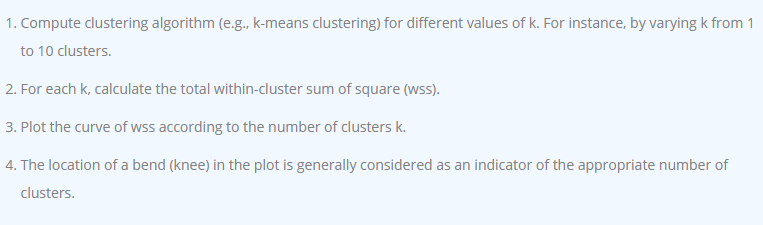

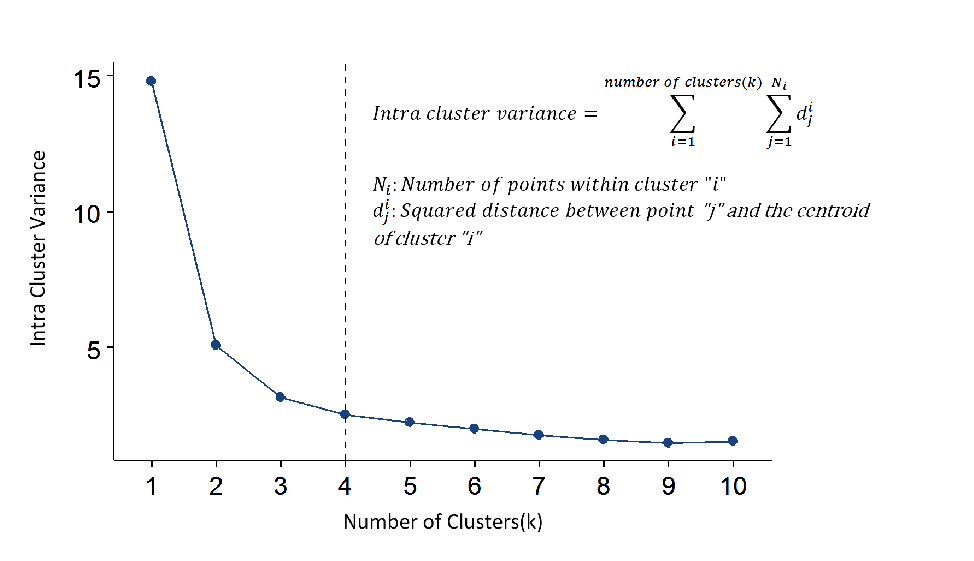


And from this graph, we determine the number of clusters we’d like to keep. To that effect, we use the Elbow-method. The approach consists of looking for a kink or elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. In this instance, the kink comes at the 7 clusters mark. 

In [ ]:
wcss = []
cluster_range = range(1, 11)
for i in cluster_range:
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
            # generate the plot
plt.plot(cluster_range, wcss)  # creating the graph between WCSS and the number of clusters
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

#### Average silhouette method

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].
Where 1 means that points are very close to their own cluster and far from other clusters, whereas -1 indicates that points are close to the neighboring clusters.

The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.
The silhouette plots can be used to select the most optimal value of the K (no. of cluster) in K-means clustering.
The aspects to look out for in Silhouette plots are cluster scores below the average silhouette score, wide fluctuations in the size of the clusters, and also the thickness of the silhouette plot.

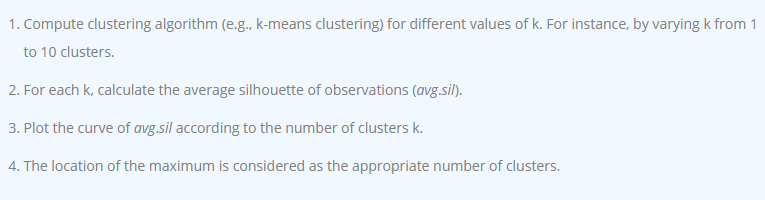

<a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html" >refer SKLearn for code </a>

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6,7]
avg_silhouette(df,range_n_clusters)

#### Gap statistic method
- Gap Statistic is a method from researchers  Tibshirani, Walther, Hastie to determine the inherent number of clusters in a dataset with k-means clustering.
- API : <a href="https://libraries.io/pypi/gap-stat">here</a>
- Paper :<a href="https://statweb.stanford.edu/~gwalther/gap">here </a>

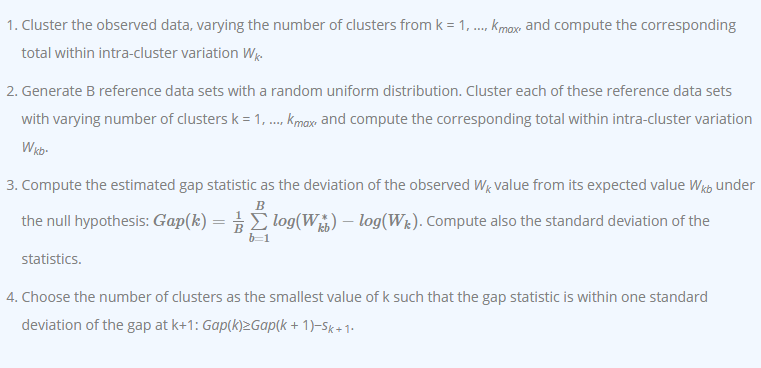

In [ ]:
gap_statistics(df)    

### Clustering algorithms

#### K-means

In [ ]:
#KMeans++ removes the drawback of K means which is it is dependent on initialization of centroid
kmodel=KMeans(init='k-means++', n_clusters=2, n_init=10,max_iter=500)
kmodel.fit(df)
df['cluster_label']=kmodel.labels_
df.head()

<b>Vizualising the clusters using PCA</b>
>. PCA is an algorithm that is used for dimensionality reduction - meaning, informally, that it can take in a DataFrame with many columns and return a DataFrame with a reduced number of columns that still retains much of the information from the columns of the original DataFrame. The columns of the DataFrame produced from the PCA procedure are called Principal Components. We will use these principal components to help us visualize our clusters in 1-D, 2-D, and 3-D space, since we cannot easily visualize the data we have in higher dimensions.

In [ ]:
plot_k_means_2D(df,2)

In [ ]:
plot_k_means_3D(df,2)

### Model After Clustering

In [ ]:
df.head()

In [ ]:
list_of_clusters = df['cluster_label'].unique()

In [ ]:
 from sklearn.ensemble import RandomForestRegressor
dict_={}
for i in list_of_clusters:
                # get data for each
    cluster_data = df[df['cluster_label'] == i]

                # step 4.1 get cluster features & labels
    cluster_features =df.drop(['Item_Outlet_Sales', 'cluster_label'], axis=1)
    cluster_label = df['Item_Outlet_Sales']

                # step 4.2 split data into test & train
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(cluster_features,
                                                                                            cluster_label,
                                                                                            test_size=1 / 3,
                                                                                            random_state=0)
      
    scores = []

   
    estimator = RandomForestRegressor()
    estimator.fit(x_train,y_train)
    scores.append(
        {'train_score': estimator.score(x_train,y_train),
         'test_score' :estimator.score(x_test,y_test)
        })    
    dict_[i]=scores

In [ ]:
dict_

In [ ]:
final_models={}
for i in dict_.keys():
    inner_list=dict_[i]
    final_models['cluster'+str(i)]=(inner_dict[0])
    

In [ ]:
pd.DataFrame(final_models).T

In [ ]:
df.columns

In [ ]:

df.groupby(['cluster_label']).agg({
    'mean'
})


<b> INSIGHTS </b>
- There are no intrinsic clusters in data , since the mean is very close for the two  clusters . Also the model & scores donot change when fitted to data before or after clustering

## Compare multiple regression models using  pycaret

In [ ]:
from pycaret.utils import version
version()

In [ ]:
df.columns

In [193]:
features =list(df.drop(columns=['Item_Outlet_Sales']).columns)

In [194]:
import pycaret
from pycaret.regression import *
reg = setup(df, target = 'Item_Outlet_Sales',numeric_features=features, session_id=786)

,Description,Value
0,session_id,786
1,Target,Item_Outlet_Sales
2,Original Data,"(5005, 31)"
3,Missing Values,False
4,Numeric Features,30
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3503, 25)"


In [86]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,201,3.551e+05,588.6,0.887,0.2769,0.1387,0.618
rf,Random Forest Regressor,321.8,4.049e+05,631.7,0.8706,0.3129,0.2228,0.786
catboost,CatBoost Regressor,511.4,5.774e+05,757.6,0.8138,0.5019,0.4217,6.562
dt,Decision Tree Regressor,264.8,6.438e+05,793.3,0.7952,0.3792,0.166,0.02
lightgbm,Light Gradient Boosting Machine,539.9,6.468e+05,802.5,0.7914,0.4783,0.4347,0.082
gbr,Gradient Boosting Regressor,711.1,1.009e+06,1004,0.6741,0.5512,0.5599,0.224
lasso,Lasso Regression,848.2,1.297e+06,1138,0.5818,0.7174,0.9706,0.014
br,Bayesian Ridge,848.5,1.298e+06,1138,0.5816,0.7203,0.9697,0.016
lr,Linear Regression,849.1,1.298e+06,1138,0.5815,0.715,0.9737,0.016
ridge,Ridge Regression,849,1.298e+06,1138,0.5815,0.7145,0.9729,0.015


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=786, verbose=0, warm_start=False)

In [195]:
create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,463.9,4.977e+05,705.5,0.8551,0.4763,0.3916
1,531.2,6.833e+05,826.6,0.7775,0.4907,0.4284
2,506.7,5.042e+05,710.1,0.8283,0.5176,0.4542
3,511.3,5.587e+05,747.5,0.8163,0.4997,0.4483
4,487.2,4.684e+05,684.4,0.8366,0.4802,0.3903
5,554.7,7.858e+05,886.5,0.7604,0.5679,0.4071
6,530.9,5.479e+05,740.2,0.8021,0.4951,0.4408
7,510,5.159e+05,718.3,0.8157,0.522,0.5017
8,506.4,6.088e+05,780.3,0.8313,0.55,0.386
9,512.1,6.029e+05,776.5,0.8146,0.4201,0.3682


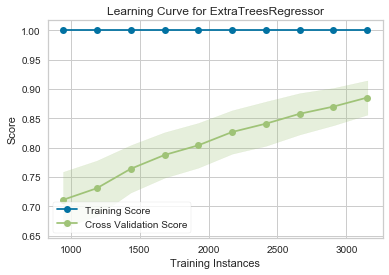

In [87]:
dt=create_model('et')
plot_model(estimator = dt, plot = 'learning')

## References
- Application of Factor Analysis to k-means Clustering Algorithm on Transportation Data.
<a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.673.5439&rep=rep1&type=pdf">Read the
    paper </a>
- <a href="https://medium.com/@masarudheena/4-best-ways-to-find-optimal-number-of-clusters-for-clustering-with-python-code-706199fa957c">Find Optimal Number of Clusters </a>
- <a href="https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c"> Silhouette coefficient </a>
- <a href="https://github.com/milesgranger/gap_statistic/blob/master/Example.ipynb">Gap Statistics</a>
- <a href="https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python">PCA</a>
- <a href="https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2">principal-component-analysis-and-k-means-clustering</a>
- <a href="https://365datascience.com/pca-k-means/" >PCA & Kmeans </a>
- <a href="https://www.datacamp.com/community/tutorials/introduction-factor-analysis" >Factor analysis</a>
- <a href="https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba">Outlier detection & removal </a>
- <a href="https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019">HAC </a>
- <a href="https://towardsdatascience.com/clustering-evaluation-strategies-98a4006fcfc">Cluster evaluation</a>
- <a href="https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/">DBSCAN</a>
- <a href="https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e" >HDBSCAN </a>
- <a href="https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a">DBSCAN vs  HDBSCAN</a>
- <a href="https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam#:~:text=The%20value%20of%202%20and,is%20above%20average%20silhouette%20scores.">Silhouette </a>
- <a href="https://www.researchgate.net/figure/Examples-of-cluster-plots-Cluster-plots-for-two-SNPs-One-spot-corresponds-to-one_fig1_40695417">Cluster plot</a>

## FUNCTIONS

In [117]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

### normalize_df()

In [118]:
def normalize_df(df):
#normalizing before VIF
    min_max_scaler = preprocessing.MinMaxScaler()
    df_scaled = min_max_scaler.fit_transform(df)
    Scaled_df_used=pd.DataFrame(df_scaled,columns=df.columns.tolist(),index=df.index)
    return df_scaled,Scaled_df_used

### calculate_vif_(X, thresh)

In [119]:
#VIF Treatment 
from joblib import Parallel, delayed

# Defining the function that you will run later
import time 
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif_(X, thresh=5):
#     for thresh in thresh:
#         print('running for threshold= ',thresh)
        variables = [X.columns[i] for i in range(X.shape[1])]
        dropped=True
        while dropped:
            dropped=False
            print(len(variables))
            vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) 
                                                for ix in range(len(variables)))

            maxloc = vif.index(max(vif))
            if max(vif) > thresh:
                print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
                variables.pop(maxloc)
                dropped=True

        print('Remaining variables:')
        print([variables])
        #return X[[i for i in variables]]
        return (variables)

### PCA_components(df)

In [120]:
import plotly.express as px
from sklearn.decomposition import PCA

def PCA_components(df):
    """
    input to this function is scaled array of dataframe to be used
    """
    pca = PCA()
    pca.fit(df)
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

    return (px.area(
        x=range(1, exp_var_cumul.shape[0] + 1),
        y=exp_var_cumul,
        labels={"x": "# Components", "y": "Explained Variance"}
    ))
    

### elbow_kmeans(Cluster_data_used)

In [121]:
#!pip install yellowbrick
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer

def elbow_kmeans(Cluster_data_used):
#within cluster sunm of squares=WCSS
    WCSS = []
    #distortions = []
    for i in range(1,31):
        kmeans = KMeans(n_clusters=i,init = 'k-means++',max_iter=500, n_init = 10, random_state = 0)
        kmeans.fit(Cluster_data_used)
        WCSS.append(kmeans.inertia_)
        #using scipy
        #distortions.append(sum(np.min(cdist(Cluster_data_used, kmeans.cluster_centers_, 'euclidean'), axis=1)) / Cluster_data_used.shape[0])

    plt.plot(range(1,31),WCSS,marker='o', color='c')
    plt.title('The Elbow Method showing the optimal k')
    plt.xlabel('# of clusters')
    plt.ylabel('WCSS')

    plt.show()
    # Elbow Method for K means
    # Import ElbowVisualizer
    
    model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
    visualizer.fit(Cluster_data_used)        # Fit data to visualizer
    visualizer.show()   
    return 

### avg_silhouette(Cluster_data_used,range_n_clusters)

In [122]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer

def avg_silhouette(Cluster_data_used,range_n_clusters):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
#         fig, ax1 = plt.subplots(1, 1)
#         fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
#         ax1.set_xlim([-0.1, 1])
#         # The (n_clusters+1)*10 is for inserting blank space between silhouette
#         # plots of individual clusters, to demarcate them clearly.
#         ax1.set_ylim([0, Cluster_data_used.shape[0] + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(Cluster_data_used)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(Cluster_data_used, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
                 
    plt.show()
    
    # Silhouette Score for K means
    # Import ElbowVisualizer
    model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
    visualizer.fit(Cluster_data_used)        # Fit the data to the visualizer
    visualizer.show() 
    return 

### gap_statistics(Cluster_data_used)

In [123]:
# !pip install gap-stat==2.0.1
# !pip install gapstat-rs

In [124]:
# !pip install gap-stat==2.0.1
# !pip install gapstat-rs

from gap_statistic import OptimalK

def gap_statistics(Cluster_data_used):
    optimalK = OptimalK(parallel_backend='rust')
    n_clusters = optimalK(Cluster_data_used, cluster_array=np.arange(1, 8))
    print('Optimal clusters: ', n_clusters)
    #print(optimalK.gap_df)
    plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
    plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
                optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
    plt.grid(True)
    plt.xlabel('Cluster Count')
    plt.ylabel('Gap Value')
    plt.title('Gap Values by Cluster Count')
    plt.show()

### dunn(k_list)

In [125]:
#function for dun index
#couldnot import jqmcvi so copying the relevant three functions to calculating dunn index

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)
    
def dunn(k_list):
    """ Dunn index [CVI]
    
    Parameters
    ----------
    k_list : list of np.arrays
        A list containing a numpy array for each cluster |c| = number of clusters
        c[K] is np.array([N, p]) (N : number of samples in cluster K, p : sample dimension)
    """
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di


### get_scores(data,data_with_labels,model,label_column,algorithm_name)

In [126]:
def get_scores(data,data_with_labels,model,label_column,algorithm_name):
    """
    data is array version of data fit into the model,model is clustering model,
    label_colun is the column that has labels predicted, name of algorithm
    """
    silhouette_score=metrics.silhouette_score(data, model.labels_, metric='euclidean')
    calinski_harabasz_score=metrics.calinski_harabasz_score(data, model.labels_)
    davies_bouldin_score=metrics.davies_bouldin_score(data, model.labels_)
    te=data_with_labels.copy()
    klist=[]
    clus={}
    for i in np.unique(te[label_column]):
        clus[i]=te.loc[te[label_column]==i]
    for (key,values) in clus.items():
        klist.append(clus[key].values)
    dun_val=dunn(klist)
    metrics_=["silhouette_score","calinski_harabasz_score","davies_bouldin_score","dunn index"]
    algorithms_=[algorithm_name]
    score=pd.DataFrame([silhouette_score,calinski_harabasz_score,davies_bouldin_score,dun_val],columns=algorithms_,index=metrics_)
    return score 

### K_means(Cluster_data_used,k)

In [127]:
from sklearn import metrics
from time import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def K_means(Cluster_data_used,k):
    X=np.array(Cluster_data_used)
    #KMeans++ removes the drawback of K means which is it is dependent on initialization of centroid
    kmodel=KMeans(init='k-means++', n_clusters=k, n_init=10,max_iter=500)
    kmodel.fit(X)
    clusters = kmodel.predict(Cluster_data_used)
    Cluster_data_used_copy=Cluster_data_used.copy()
    Cluster_data_used_copy["Cluster_Kmeans"]=clusters
    score=get_scores(X,Cluster_data_used_copy,kmodel,"Cluster_Kmeans","K-means")
    return score 

### plot_k_means_2D()

In [128]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def plot_k_means_2D(df,n_clusters):
    Cluster_data_used=df
    X=np.array(Cluster_data_used)
    #KMeans++ removes the drawback of K means which is it is dependent on initialization of centroid
    kmodel=KMeans(init='k-means++', n_clusters=n_clusters, n_init=10,max_iter=500)
    kmodel.fit(X)
    clusters = kmodel.predict(Cluster_data_used)
    Cluster_data_used_copy=Cluster_data_used.copy()
    Cluster_data_used_copy["Cluster_Kmeans"]=clusters
    ############################################################
    #plotX is a DataFrame containing 5000 values sampled randomly from X
    plotX = pd.DataFrame(np.array(Cluster_data_used_copy))

    #Rename plotX's columns since it was briefly converted to an np.array above
    plotX.columns = Cluster_data_used_copy.columns

    #PCA with one principal component
    pca_1d = PCA(n_components=1)

    #PCA with two principal components
    pca_2d = PCA(n_components=2)

    #PCA with three principal components
    pca_3d = PCA(n_components=3)

    #This DataFrame holds that single principal component mentioned above
    PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    #This DataFrame contains the two principal components that will be used
    #for the 2-D visualization mentioned above
    PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    #And this DataFrame contains three principal components that will aid us
    #in visualizing our clusters in 3-D
    PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    PCs_1d.columns = ["PC1_1d"]

    #"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
    #And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
    PCs_2d.columns = ["PC1_2d", "PC2_2d"]

    PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
    #We concatenate these newly created DataFrames to plotX so that they can be used by plotX as columns.
    plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')

    cluster0 = plotX[plotX["Cluster_Kmeans"] == 0]
    cluster1 = plotX[plotX["Cluster_Kmeans"] == 1]
    cluster2 = plotX[plotX["Cluster_Kmeans"] == 2]
    cluster3 = plotX[plotX["Cluster_Kmeans"] == 3]
    #cluster4 = plotX[plotX["Cluster_Kmeans"] == 4]

#####################################################################
    trace1 = go.Scatter(
                        x = cluster0["PC1_2d"],
                        y = cluster0["PC2_2d"],
                        mode = "markers",
                        name = "Cluster 1",
                        marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                        text = None)

    #trace2 is for 'Cluster 1'
    trace2 = go.Scatter(
                        x = cluster1["PC1_2d"],
                        y = cluster1["PC2_2d"],
                        mode = "markers",
                        name = "Cluster 2",
                        marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                        text = None)

    #trace3 is for 'Cluster 3'
    trace3 = go.Scatter(
                        x = cluster2["PC1_2d"],
                        y = cluster2["PC2_2d"],
                        mode = "markers",
                        name = "Cluster 3",
                        marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                        text = None)

    #trace4 is for 'Cluster 4'
    trace4 = go.Scatter(
                        x = cluster3["PC1_2d"],
                        y = cluster3["PC2_2d"],
                        mode = "markers",
                        name = "Cluster 4",
                        marker = dict(color = 'rgba(255, 255, 100, 0.8)'),
                        text = None)

    # #trace5 is for 'Cluster 5'
    # trace5 = go.Scatter(
    #                     x = cluster4["PC1_2d"],
    #                     y = cluster4["PC2_2d"],
    #                     mode = "markers",
    #                     name = "Cluster 5",
    #                     marker = dict(color = 'rgba(255, 255, 2, 0.8)'),
    #                     text = None)

    data = [trace1, trace2, trace3,trace4]#,trace5]

    title = "Visualizing Clusters in Two Dimensions Using PCA"

    layout = dict(title = title,
                  xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
                 )

    fig = dict(data = data, layout = layout)

    iplot(fig)

### plot_k_means_3D()

In [129]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def plot_k_means_3D(df,n_clusters):
    Cluster_data_used=df
    X=np.array(Cluster_data_used)
    #KMeans++ removes the drawback of K means which is it is dependent on initialization of centroid
    kmodel=KMeans(init='k-means++', n_clusters=n_clusters, n_init=10,max_iter=500)
    kmodel.fit(X)
    clusters = kmodel.predict(Cluster_data_used)
    Cluster_data_used_copy=Cluster_data_used.copy()
    Cluster_data_used_copy["Cluster_Kmeans"]=clusters
    ############################################################
    #plotX is a DataFrame containing 5000 values sampled randomly from X
    plotX = pd.DataFrame(np.array(Cluster_data_used_copy))

    #Rename plotX's columns since it was briefly converted to an np.array above
    plotX.columns = Cluster_data_used_copy.columns

    #PCA with one principal component
    pca_1d = PCA(n_components=1)

    #PCA with two principal components
    pca_2d = PCA(n_components=2)

    #PCA with three principal components
    pca_3d = PCA(n_components=3)

    #This DataFrame holds that single principal component mentioned above
    PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    #This DataFrame contains the two principal components that will be used
    #for the 2-D visualization mentioned above
    PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    #And this DataFrame contains three principal components that will aid us
    #in visualizing our clusters in 3-D
    PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["Cluster_Kmeans"], axis=1)))

    PCs_1d.columns = ["PC1_1d"]

    #"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
    #And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
    PCs_2d.columns = ["PC1_2d", "PC2_2d"]

    PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
    #We concatenate these newly created DataFrames to plotX so that they can be used by plotX as columns.
    plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')

    cluster0 = plotX[plotX["Cluster_Kmeans"] == 0]
    cluster1 = plotX[plotX["Cluster_Kmeans"] == 1]
    cluster2 = plotX[plotX["Cluster_Kmeans"] == 2]
    cluster3 = plotX[plotX["Cluster_Kmeans"] == 3]
    #cluster4 = plotX[plotX["Cluster_Kmeans"] == 4]

#####################################################################
    trace1 = go.Scatter3d(
                    x = cluster0["PC1_3d"],
                    y = cluster0["PC2_3d"],
                    z = cluster0["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

    #trace2 is for 'Cluster 1'
    trace2 = go.Scatter3d(
                        x = cluster1["PC1_3d"],
                        y = cluster1["PC2_3d"],
                        z = cluster1["PC3_3d"],
                        mode = "markers",
                        name = "Cluster 2",
                        marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                        text = None)

    #trace3 is for 'Cluster 3'
    trace3 = go.Scatter3d(
                        x = cluster2["PC1_3d"],
                        y = cluster2["PC2_3d"],
                        z = cluster2["PC3_3d"],
                        mode = "markers",
                        name = "Cluster 3",
                        marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                        text = None)

    #trace4 is for 'Cluster 4'
    trace4 = go.Scatter3d(
                        x = cluster3["PC1_3d"],
                        y = cluster3["PC2_3d"],
                        z = cluster3["PC3_3d"],
                        mode = "markers",
                        name = "Cluster 4",
                        marker = dict(color = 'rgba(255, 255, 100, 0.8)'),
                        text = None)

    # #trace5 is for 'Cluster 5'
    # trace5 = go.Scatter3d(
    #                     x = cluster4["PC1_3d"],
    #                     y = cluster4["PC2_3d"],
    #                     z = cluster4["PC3_3d"],
    #                     mode = "markers",
    #                     name = "Cluster 5",
    #                     marker = dict(color = 'rgba(255, 255, 2, 0.8)'),
    #                     text = None)

    data = [trace1, trace2, trace3,trace4]#,trace5]

    title = "Visualizing Clusters in Three Dimensions Using PCA"

    layout = dict(title = title,
                  xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
                 )

    fig = dict(data = data, layout = layout)

    iplot(fig)
